# 1. Import Libraries 

In [1]:
import glob
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
pd.set_option('display.max_columns', None)

import cv2

import Utility_functions as ut
import Custom_Evaluation as ce

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

#Skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint
from torch.utils.data import TensorDataset, DataLoader

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score, balanced_accuracy_score, f1_score, recall_score 

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#Distnce Matrix
from scipy.spatial import distance_matrix, distance
from scipy.special import softmax

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from sklearn.manifold import TSNE

import argparse
import optuna
from optuna.integration import SkorchPruningCallback

data_dir = 'C:/Dissertation/Data/'

In [2]:
%load_ext autoreload
%autoreload 2

# 2. Import Data

In [3]:
Final_Images_df, predicate_df = ut.AWA2DataLoader(data_dir, data_type = "ResNet101-Features", 
                                                  Resnet101Type = 1, 
                                                  animal_attributes = 'AwA2', 
                                                  VectorType = 'Binary')

#data_type options
#1. "ResNet101-Features" to load Extracted Resnet101 features Avg. Time - 12 secs
#2. "Images"

#Resnet101Type
# 1 - Using Resnet Features provided with data
# 2 - Using Resnet Features extracted by Abhimanyu Acharya using a pretrainied Resnet101

# animal_attribute
#1. "AwA2" - As provided with AwA2 data
#2. "Custom Animal Attribute KG" - Custom KGs
#3. "Custom KG Extended 01" - Custom KGs with ontology alignment
#3. "Custom KG Extended 02" - Custom KGs with ontology alignment + vector combination
#4. "Word2Vec" - word2vec-google-news-300
#4. "Word2Vec Extended" - Extended Word2Vec
#5. "Dbnary" - Dbnary Knowledge Graph/Wiktionary (KGVec2Go Wiktionary/DBnary)
#6. "DBpedia" - DBPedia Knowledge Graph (KGVec2Go Classic RDF2vec: 500 walks, depth: 4, SG, 200 dimensions)
#7. "WordNet" - WordNet Knowledge Graph (KGVec2Go WordNet)
#8. "Custom Animal Attribute KG Extended" - Extended Custom KGs

Using Resnet101 Features provided with data
Animal Attributes Included - Binary Vector
Execution time: 12.253990411758423 seconds


# 3. Split Data in Predefined Test, Train & Validation for ZSL

In [4]:
trainval_df, TrainData01, ValData01, TrainData02, ValData02, TrainData03, ValData03, Seen_test_df, Unseen_test_df = ut.TestTrainValsplitdata_dir(data_dir, Final_Images_df)

  Training - Validation Split 01 
 Train Classes  
 Number of Classes 27 
 ['antelope' 'buffalo' 'chihuahua' 'collie' 'cow' 'elephant' 'fox'
 'german+shepherd' 'grizzly+bear' 'hippopotamus' 'humpback+whale'
 'killer+whale' 'lion' 'mouse' 'otter' 'persian+cat' 'pig' 'polar+bear'
 'rhinoceros' 'siamese+cat' 'skunk' 'spider+monkey' 'squirrel' 'tiger'
 'weasel' 'wolf' 'zebra'] 

 Validation Classes  
 Number of Classes 13 
 ['beaver' 'chimpanzee' 'dalmatian' 'deer' 'giant+panda' 'gorilla'
 'hamster' 'leopard' 'mole' 'moose' 'ox' 'rabbit' 'raccoon'] 

  Training - Validation Split 02 
 Train Classes  
 Number of Classes 27 
 ['buffalo' 'chimpanzee' 'collie' 'cow' 'deer' 'elephant' 'german+shepherd'
 'giant+panda' 'gorilla' 'hamster' 'hippopotamus' 'humpback+whale'
 'leopard' 'lion' 'mole' 'moose' 'mouse' 'polar+bear' 'rabbit' 'raccoon'
 'rhinoceros' 'siamese+cat' 'spider+monkey' 'squirrel' 'tiger' 'weasel'
 'wolf'] 

 Validation Classes  
 Number of Classes 13 
 ['antelope' 'beaver' 'chihua

# 4. Define Dependent and Independent variables 

In [5]:
# Pre defined Test split 01
X1 = TrainData01.iloc[:,1:2049]
y1 = TrainData01.iloc[:,2051:-18]

# Pre defined Test split 02
X2 = TrainData02.iloc[:,1:2049]
y2 = TrainData02.iloc[:,2051:-18]

# Pre defined Test split 03
X3 = TrainData03.iloc[:,1:2049]
y3 = TrainData03.iloc[:,2051:-18]

X_finaltrain = trainval_df.iloc[:,1:2049]
y_finaltrain = trainval_df.iloc[:,2051:-18]

In [6]:
#Train val split for testing projection network
X_train1,X_val_seen_classes1,y_train1,y_val_seen_classes1 = train_test_split(X1,y1,stratify=y1,test_size=0.1,random_state = 0)

X_train2,X_val_seen_classes2,y_train2,y_val_seen_classes2 = train_test_split(X2,y2,stratify=y2,test_size=0.1,random_state = 0)

X_train3,X_val_seen_classes3,y_train3,y_val_seen_classes3 = train_test_split(X3,y3,stratify=y3,test_size=0.1,random_state = 0)

#Stratify Final train data 
X_train_final,X_val_seen_classes_final,y_train_final,y_val_seen_classes_final = train_test_split(X_finaltrain,y_finaltrain,stratify=y_finaltrain,test_size=0.002,random_state = 0)

# 5. Define Animal Attributes

In [7]:
animal_attributes_df = pd.read_csv("C:/Dissertation/Data/AwA2-data/Animals_with_Attributes2/predicates.txt", sep = '\t',header = None, names = ['predicates'])
animal_attributes_list = animal_attributes_df['predicates'].tolist()
print(animal_attributes_list)

['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red', 'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless', 'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers', 'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail', 'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns', 'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels', 'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal', 'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate', 'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects', 'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker', 'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush', 'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean', 'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart', 'group', 'solitary', 'nestspot', 'domestic']


# 6. Load Taxonomy Information

In [8]:
taxonomy_df = pd.read_csv("C:/Dissertation/Data/Mammal Taxonomy/Mammal Taxonomy_noduplicates.csv")
taxonomy_df.drop(['subgenus','biogeographicRealm','CMW_sciName'], axis = 1, inplace = True)
taxonomy_df.head()

sciName  animal_label  animal_class   mainCommonName  \
0  Antilope_cervicapra             1      antelope        Blackbuck   
1         Ursus_arctos             2  grizzly+bear       Brown Bear   
2         Orcinus_orca             3  killer+whale     Killer Whale   
3      Aplodontia_rufa             4        beaver  Mountain Beaver   
4     Canis_familiaris             5     dalmatian     Domestic Dog   

                                    otherCommonNames     class   infraclass  \
0                                    Indian Antelope  Mammalia  Placentalia   
1                           Grizzly Bear|Kodiak Bear  Mammalia  Placentalia   
2                                               Orca  Mammalia  Placentalia   
3  Boomer|Sewellel|Point Arena Mountain Beaver|Po...  Mammalia  Placentalia   
4  Dog|Dingo|Feral Dog|New Guinea Singing Dog|Vil...  Mammalia  Placentalia   

       magnorder        superorder         order      suborder infraorder  \
0  Boreoeutheria    Laurasiatheria  ARTIODACTYLA    RUMINANTIA     PECORA   
1  Boreoeutheria    Laurasiatheria     CARNIVORA    CANIFORMIA  ARCTOIDEA   
2  Boreoeutheria    Laurasiatheria  ARTIODACTYLA  WHIPPOMORPHA    CETACEA   
3  Boreoeutheria  Euarchontoglires      RODENTIA  SCIUROMORPHA        NaN   
4  Boreoeutheria    Laurasiatheria     CARNIVORA    CANIFORMIA   CANOIDEA   

    parvorder   superfamily         family       subfamily       tribe  \
0         NaN           NaN        BOVIDAE     ANTILOPINAE  ANTILOPINI   
1         NaN      URSOIDEA        URSIDAE         URSINAE         NaN   
2  ODONTOCETI  DELPHINOIDEA    DELPHINIDAE  INCERTAE SEDIS         NaN   
3         NaN           NaN  APLODONTIIDAE             NaN         NaN   
4         NaN           NaN        CANIDAE             NaN         NaN   

        genus  
0    Antilope  
1       Ursus  
2     Orcinus  
3  Aplodontia  
4       Canis

In [11]:
y1.to_csv('taxo.csv')

# 7. Set up Neural Network for multilabel classifciation

### 7.1 Define DNN for projection network

In [32]:
class ProjectionNetwork1(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork1, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, 213) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out   

In [33]:
class ProjectionNetwork2(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork2, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, 213) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out   

In [34]:
class ProjectionNetwork3(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork3, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, num_units) 
        self.fc4 = nn.Linear(num_units, 213) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out   

### 7.2 Define evaluation criterea and checkpoint for projection network

In [18]:
# Create Skorch EPOCHScoring   
train_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'train_recall_macro', on_train = True)
valid_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'valid_recall_macro', on_train = False)

# Create Checkpoint
CP1 = Checkpoint(monitor='valid_loss_best',dirname='exp1')
CP2 = Checkpoint(monitor='valid_loss_best',dirname='exp2')
CP3= Checkpoint(monitor='valid_loss_best',dirname='exp3')
CP_final= Checkpoint(monitor='valid_loss_best',dirname='exp_final')

### 7.3 Check for GPU

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# 8. Define Conventional Zero Shot Leaning Function

In [41]:
def CZSL(mode, split, DNN, epochs, bs, numunits, lr, optimiser, dropout, mom, wd, device, checkpoint, pred_type, dist_type):
    torch.manual_seed(0)    
    
    if mode == "Train":
        if split == 1:
            X = X_train1.astype(np.float32).values
            y = y_train1.astype(np.float32).values
            Y = y_train1
            SeenClassFeatures = X_val_seen_classes1
            SeenClassAttributes = y_val_seen_classes1
            UnseenData = ValData01
            
        if split == 2:
            X = X_train2.astype(np.float32).values
            y = y_train2.astype(np.float32).values
            Y = y_train2
            SeenClassFeatures = X_val_seen_classes2
            SeenClassAttributes = y_val_seen_classes2
            UnseenData = ValData02
            
        if split == 3:
            X = X_train3.astype(np.float32).values
            y = y_train3.astype(np.float32).values
            Y = y_train3
            SeenClassFeatures = X_val_seen_classes3
            SeenClassAttributes = y_val_seen_classes3
            UnseenData = ValData03
       
        
    if mode == "Test":
        X = X_train_final.astype(np.float32).values
        y = y_train_final.astype(np.float32).values        
        UnseenData = Unseen_test_df
    
    #Model 01
    net = NeuralNetClassifier(
    DNN,
    batch_size= bs,
    module__num_units = numunits,
    module__non_linear = optimiser,
    module__dropout = dropout,
    max_epochs=epochs,
    lr=lr,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = wd,
    train_split = ValidSplit(5),
    callbacks=[train_macro_recall_score,valid_macro_recall_score, checkpoint],
    callbacks__valid_acc=None,
    device= device
    )     
    
    #Train three models of three Train Val spilts
    print('Training DNN')
    st = time.time()   
    net.fit(X,y)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    #Plot training val curves
    print('Training Validation Loss Curve')
    train_loss = net.history[:, 'train_loss']
    valid_loss = net.history[:, 'valid_loss']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('Error Loss', fontsize=10)
    plt.legend()
    plt.show() 
    
    print('Trianing Recall Macro Curve')
    train_loss = net.history[:, 'train_recall_macro']
    valid_loss = net.history[:, 'valid_recall_macro']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('F1 Score (Macro)', fontsize=10)
    plt.legend()
    plt.show() 
    
    #load best model weights
    net.load_params(checkpoint=checkpoint)  
 
    #predict attributes for Seen classes
    if mode == "Train":
        predicted_attributes = net.predict(SeenClassFeatures.astype(np.float32).values)
        #print attribute prediction DNN performance
        print(classification_report(SeenClassAttributes.astype(np.float32).values, predicted_attributes, target_names=Y.columns))
        
        print("Recall (Macro)")
        print(recall_score(SeenClassAttributes.astype(np.float32).values, predicted_attributes, average='macro'))
    
    if mode == "Test":
        pass

    #predict attributes for Unseen classes 
    y_pred_unseen = net.predict(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    y_pred_unseen_proba = net.predict_proba(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    
    #limit search space to unseen classes 
    predicatedf_CZSL = predicate_df[predicate_df['classes'].isin((UnseenData.classes.unique()).tolist())]
    animal_attributes = np.array(predicatedf_CZSL.iloc[:,2:-18])
    animal_attributes_labels = predicatedf_CZSL['labels'].unique()
    print('Unseen Class Labels')
    print(animal_attributes_labels)
    
    #Spatialise the unseen classes using TSNE
    print('TSNE spatialisation of Unseen Classes')
    
    classes_df = predicatedf_CZSL.copy()
    classes_df.reset_index(inplace=True)
    
    embeddings = TSNE(n_components=2, verbose=0, random_state=123, perplexity=9.0)

    TSNE_predicates = embeddings.fit_transform(animal_attributes) 
    TSNE_predicates_df = pd.DataFrame(data = TSNE_predicates
                 , columns = ['Binary comp-1', 'Binary comp-2'])
    
    TSNE_predicates_df1 = pd.concat([TSNE_predicates_df,classes_df['classes']], axis = 1)
    TSNE_predicates_df1 = TSNE_predicates_df1.merge(taxonomy_df, how = 'inner', left_on = 'classes', right_on = 'animal_class')
    
    #By animal class
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('classes:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='classes:N'
    )

    display(binary_points.interactive() + text1)
    
    #By Taxonomy Family
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('order:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='order:N'
    )

    display(binary_points.interactive() + text1)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseenprob = []
    for y in y_pred_unseen_proba:
        y_pred_unseenprob.append(y[1])
        
    if pred_type == 'Probabilistic':
        dist_CZSL= (1-distance.cdist(y_pred_unseenprob, animal_attributes, dist_type))
    elif pred_type == 'Deterministic':    
        dist_CZSL= (1-distance.cdist(y_pred_unseen, animal_attributes, dist_type))
        
    CZSL_label_prediction = np.array([np.argmax(output) for output in dist_CZSL])
    
    #replace predicted labels with unseen class labels 
    if mode == "Train":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9, CZSL_label_prediction == 10, CZSL_label_prediction == 11
          , CZSL_label_prediction == 12], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]
          , animal_attributes_labels[10], animal_attributes_labels[11], animal_attributes_labels[12]], CZSL_label_prediction)
    
    if mode == "Test":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]], CZSL_label_prediction)
        
     #sort class names 
    class_labels = UnseenData[['labels','classes', 'order', 'family']]
    class_labels.sort_values(by=['labels'], inplace=True)
    animal_classes = class_labels['classes'].unique()
    
    #Assess CZSL Model performance
    print(classification_report(UnseenData['labels'], CZSL_label_prediction, target_names = animal_classes))

    cm = confusion_matrix(UnseenData['labels'], CZSL_label_prediction, normalize = 'true')
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='.1%', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(animal_classes)
    a.set_xticklabels(animal_classes)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    #predict taxonomy
    predicted_taxonomy_df = pd.DataFrame(CZSL_label_prediction, columns = ['pred_labels'])
    predicted_taxonomy_df = pd.merge(predicted_taxonomy_df, taxonomy_df,  how = 'left', left_on = 'pred_labels' , right_on = 'animal_label' )
    
    Train_family_labels = UnseenData.copy()
    Train_family_labels.sort_values(by=['order'], inplace=True)
    train_animal_family = Train_family_labels['order'].unique()
    
    print(classification_report(UnseenData['order'], predicted_taxonomy_df['order'], target_names=train_animal_family))
    
    cm = confusion_matrix(UnseenData['order'], predicted_taxonomy_df['order'], normalize = 'true')
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='.1%', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(train_animal_family)
    a.set_xticklabels(train_animal_family)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    if mode == "Train":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = True)
    if mode == "Test":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = False)
        
    return dist_CZSL, animal_attributes_labels, animal_classes    

# 9. Train Model

### 9.1 Train Validation Split 01

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.2874                0.1430        0.2572                0.1581     +  1.6368
      2        0.2406                0.1672        0.2219                0.1832     +  1.6203
      3        0.2057                0.1977        0.1901                0.2131     +  1.8430
      4        0.1776                0.2331        0.1654                0.2520     +  1.6191
      5        0.1556                0.2781        0.1460                0.3046     +  1.6292
      6        0.1384                0.3326        0.1311                0.3600     +  1.8733
      7        0.1253                0.3863        0.1195                0.4143     +  1.8851
      8        0.1148                0.4308        0.1105                0.4515     +  2.0018
      9        0.1067                0.4611    

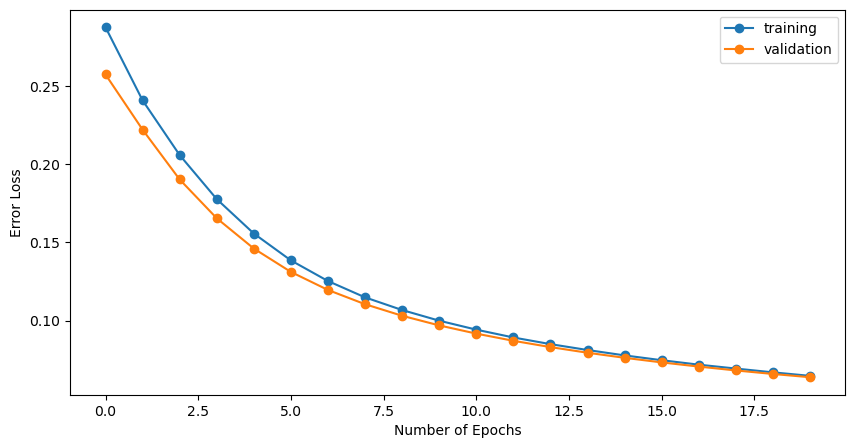

Trianing Recall Macro Curve


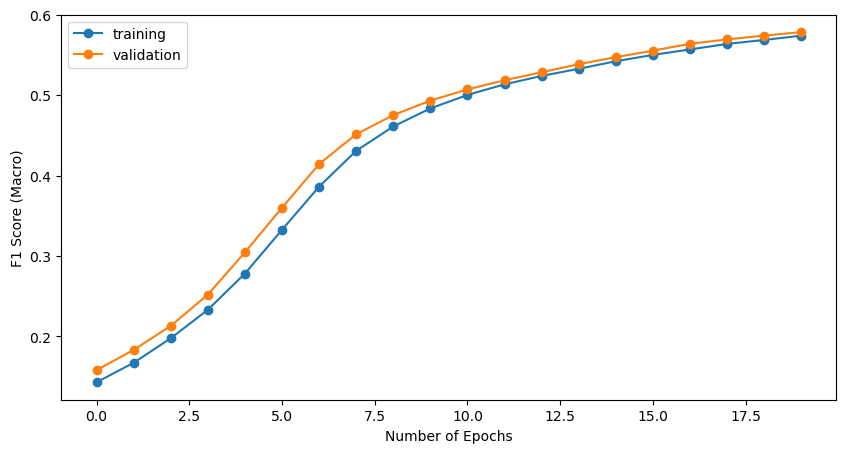

Recall (Macro)
0.5685068354781273
Unseen Class Labels
[ 4  5 12 15 16 20 21 25 26 29 39 40 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.81      0.43      0.56       152
   dalmatian       0.33      0.62      0.43       442
        mole       0.10      0.47      0.16        75
     leopard       0.47      0.98      0.63       568
       moose       0.52      0.34      0.41       554
     gorilla       0.77      0.03      0.05       709
          ox       0.52      1.00      0.68       588
  chimpanzee       0.45      0.26      0.33       566
     hamster       0.44      0.55      0.49       640
      rabbit       0.75      0.13      0.22       877
 giant+panda       0.22      0.08      0.11       692
        deer       0.92      0.83      0.88      1069
     raccoon       0.36      0.78      0.49       408

    accuracy                           0.49      7340
   macro avg       0.51      0.50      0.42      7340
weighted avg       0.57      0.49      0.44      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.42763158 0.619909

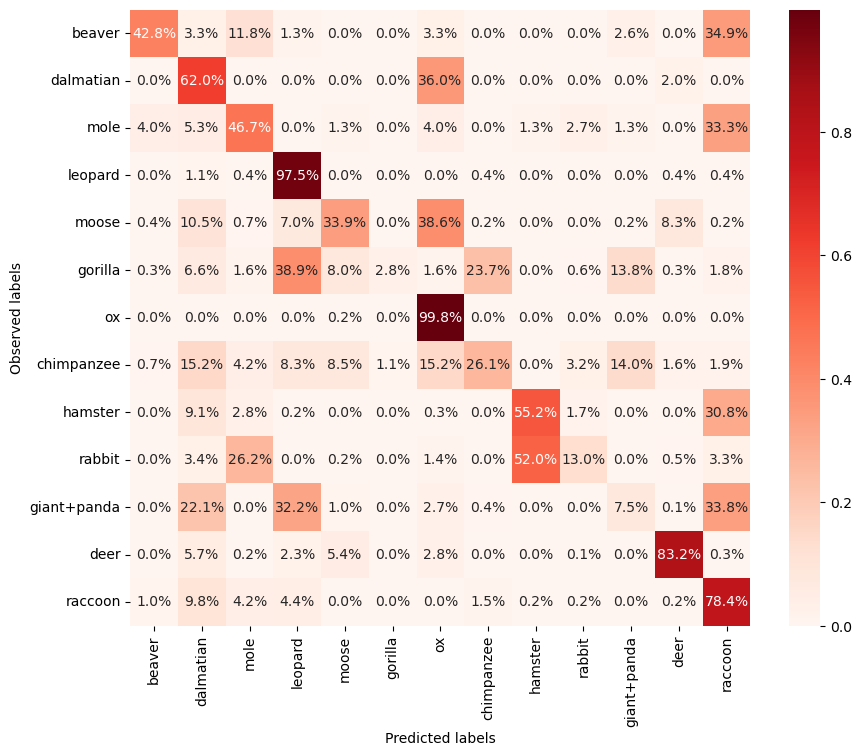

              precision    recall  f1-score   support

ARTIODACTYLA       0.82      0.91      0.86      2211
   CARNIVORA       0.60      0.89      0.72      2110
EULIPOTYPHLA       0.10      0.47      0.16        75
  LAGOMORPHA       0.75      0.13      0.22       877
    PRIMATES       0.97      0.27      0.42      1275
    RODENTIA       0.47      0.53      0.50       792

    accuracy                           0.65      7340
   macro avg       0.62      0.53      0.48      7340
weighted avg       0.73      0.65      0.62      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.91044776 0.88909953 0.46666667 0.1299886  0.26823529 0.52777778]
Top_1_accuracy for UnSeen Validation split 01 -  0.5320359372189867


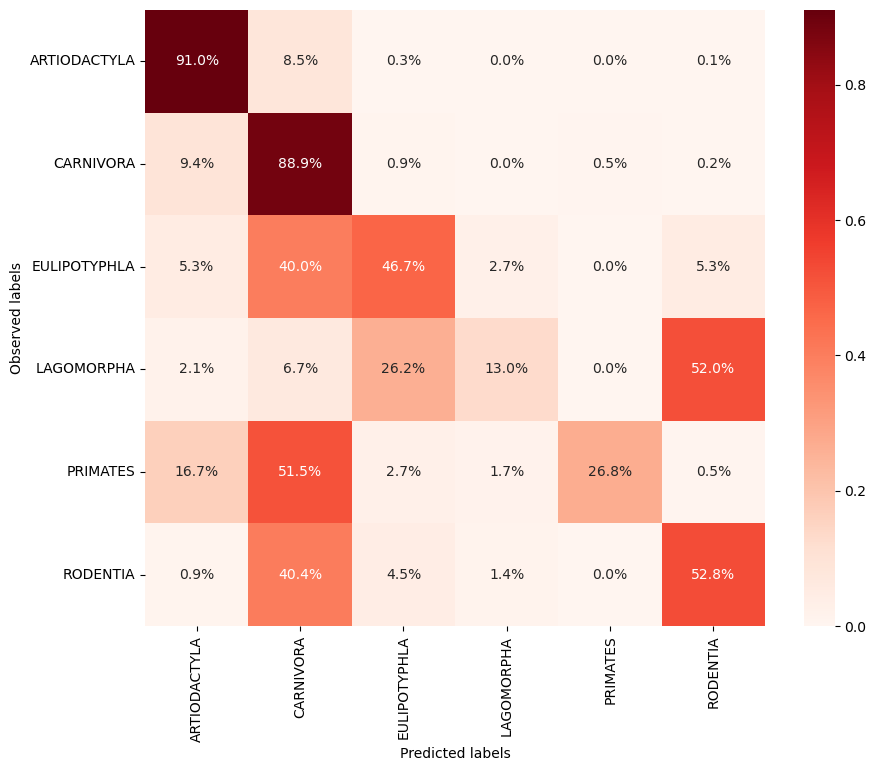

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6596471626433849 
              0         1
0        beaver  0.592105
1     dalmatian  0.769231
2          mole  0.733333
3       leopard  0.982394
4         moose  0.814079
5       gorilla  0.234133
6            ox  1.000000
7    chimpanzee  0.386926
8       hamster  0.667188
9        rabbit  0.421893
10  giant+panda  0.147399
11         deer  0.902713
12      raccoon  0.924020 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7970701518410638 
              0         1
0        beaver  0.776316
1     dalmatian  0.859729
2          mole  0.906667
3       leopard  0.985915
4         moose  0.850181
5       gorilla  0.486601
6            ox  1.000000
7    chimpanzee  0.545936
8       hamster  0.856250
9        rabbit  0.856328
10  giant+panda  0.304913
11         deer  0.974743
12      raccoon  0.958333 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8986132845962189 
              0         1
0        beaver  0.822368
1     

In [25]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 9.2 Train Validation Split 02

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.2948                0.1455        0.2643                0.1487     +  1.5775
      2        0.2486                0.1694        0.2279                0.1859     +  1.5798
      3        0.2108                0.2105        0.1920                0.2323     +  1.5262
      4        0.1786                0.2590        0.1643                0.2839     +  1.4088
      5        0.1547                0.3111        0.1441                0.3353     +  1.4678
      6        0.1375                0.3594        0.1293                0.3801     +  1.4455
      7        0.1245                0.4065        0.1179                0.4271     +  1.5369
      8        0.1143                0.4478        0.1088                0.4646     +  1.3358
      9        0.1061                0.4814    

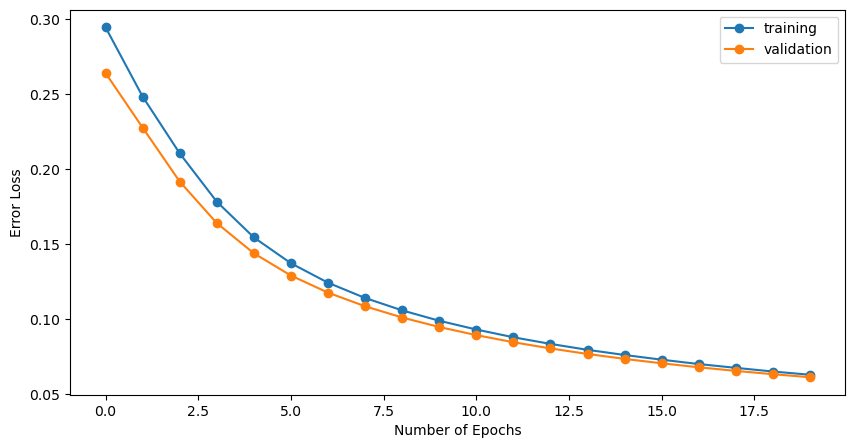

Trianing Recall Macro Curve


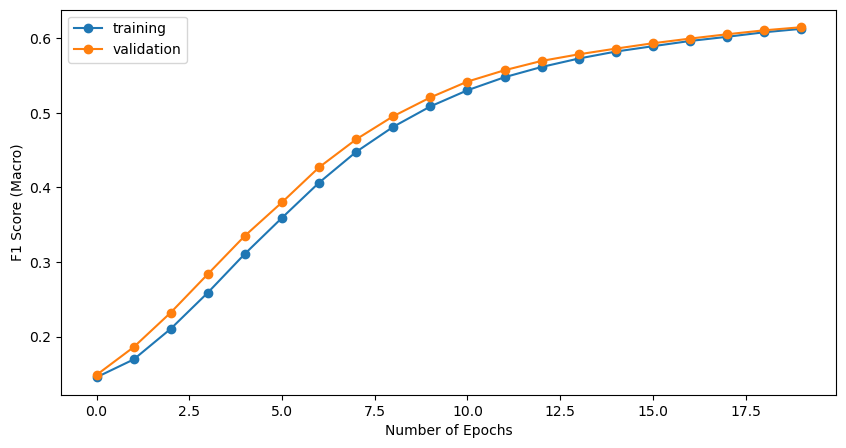

Recall (Macro)
0.6148033990401858
Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.78      0.98      0.86       864
grizzly+bear       0.81      0.66      0.73       690
killer+whale       0.89      0.71      0.79       231
      beaver       0.37      0.15      0.21       152
   dalmatian       0.29      0.68      0.41       442
 persian+cat       0.67      0.33      0.45       599
       skunk       0.16      0.18      0.17       157
          ox       0.47      0.98      0.63       588
         fox       0.59      0.80      0.68       540
   chihuahua       0.33      0.55      0.41       448
       otter       1.00      0.00      0.01       592
       zebra       0.97      0.33      0.49       942
         pig       0.26      0.17      0.21       558

    accuracy                           0.54      6803
   macro avg       0.58      0.50      0.47      6803
weighted avg       0.65      0.54      0.51      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.97569444 0.660869

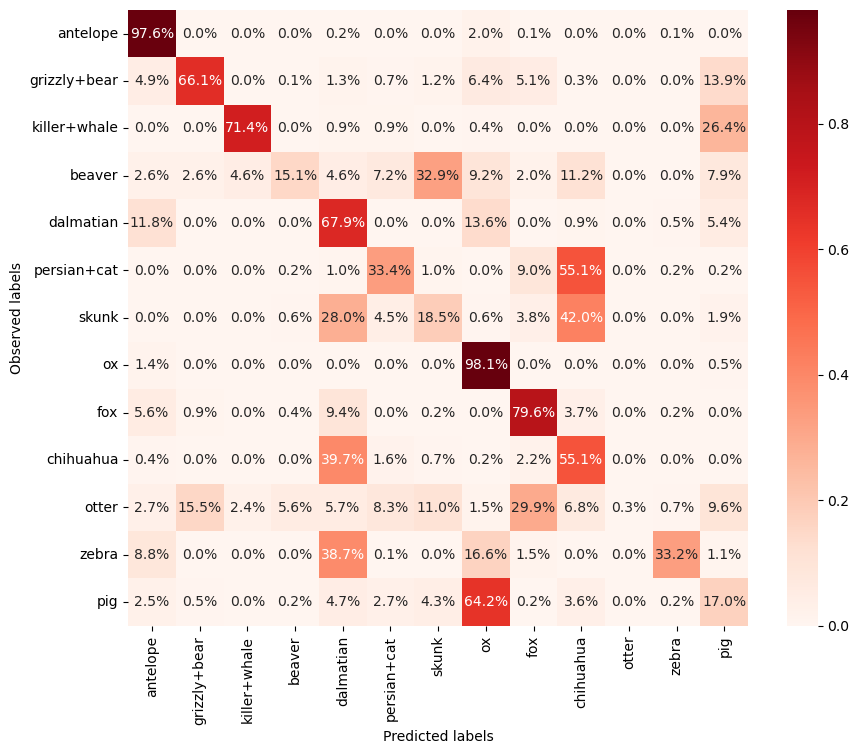

                precision    recall  f1-score   support

  ARTIODACTYLA       0.75      0.96      0.84      2241
     CARNIVORA       0.84      0.86      0.85      3468
PERISSODACTYLA       0.97      0.33      0.49       942
      RODENTIA       0.37      0.15      0.21       152

      accuracy                           0.80      6803
     macro avg       0.73      0.57      0.60      6803
  weighted avg       0.82      0.80      0.78      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.95582329 0.85870819 0.33227176 0.15131579]
Top_1_accuracy for UnSeen Validation split 01 -  0.5745297585031147


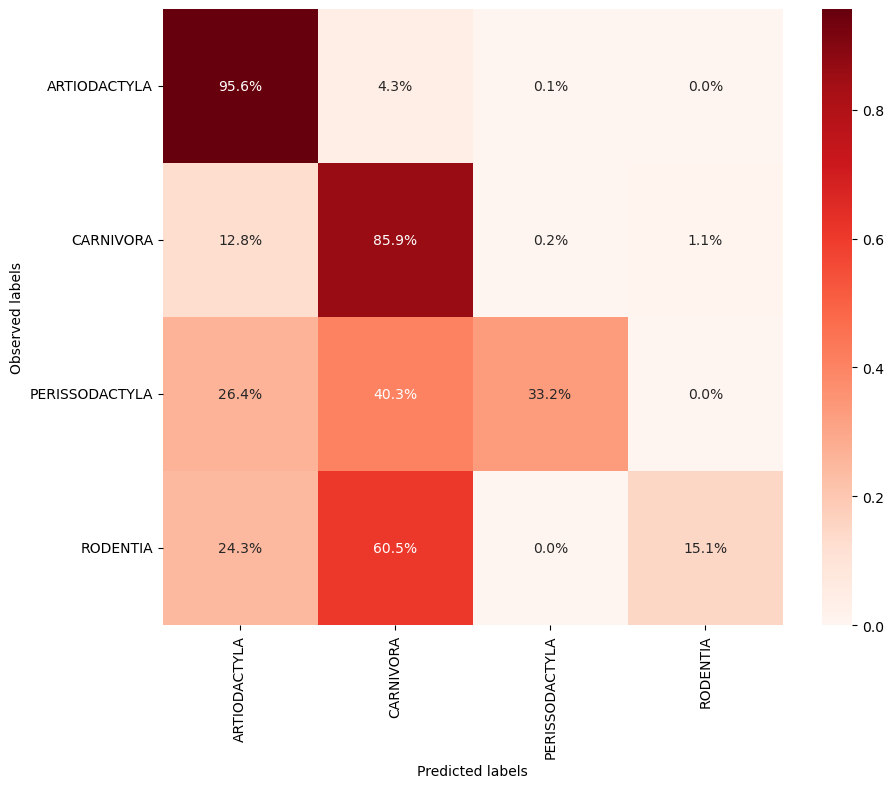

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.681127874619597 
               0         1
0       antelope  0.984954
1   grizzly+bear  0.723188
2   killer+whale  0.740260
3         beaver  0.230263
4      dalmatian  0.762443
5    persian+cat  0.644407
6          skunk  0.299363
7             ox  0.998299
8            fox  0.881481
9      chihuahua  0.959821
10         otter  0.033784
11         zebra  0.779193
12           pig  0.817204 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7681739669785252 
               0         1
0       antelope  1.000000
1   grizzly+bear  0.769565
2   killer+whale  0.748918
3         beaver  0.361842
4      dalmatian  0.904977
5    persian+cat  0.844741
6          skunk  0.560510
7             ox  0.998299
8            fox  0.953704
9      chihuahua  0.977679
10         otter  0.086149
11         zebra  0.892781
12           pig  0.887097 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8279764161144256 
               0         1
0   

In [26]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 9.3 Train Validation Split 03

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.2860                0.1425        0.2557                0.1528     +  1.5358
      2        0.2399                0.1686        0.2208                0.1875     +  1.3983
      3        0.2044                0.2062        0.1876                0.2239     +  1.5406
      4        0.1749                0.2459        0.1619                0.2667     +  1.5121
      5        0.1524                0.2871        0.1422                0.3063     +  1.4552
      6        0.1351                0.3298        0.1269                0.3483     +  1.5615
      7        0.1215                0.3771        0.1149                0.3995     +  1.5472
      8        0.1106                0.4221        0.1054                0.4428     +  1.4878
      9        0.1020                0.4567    

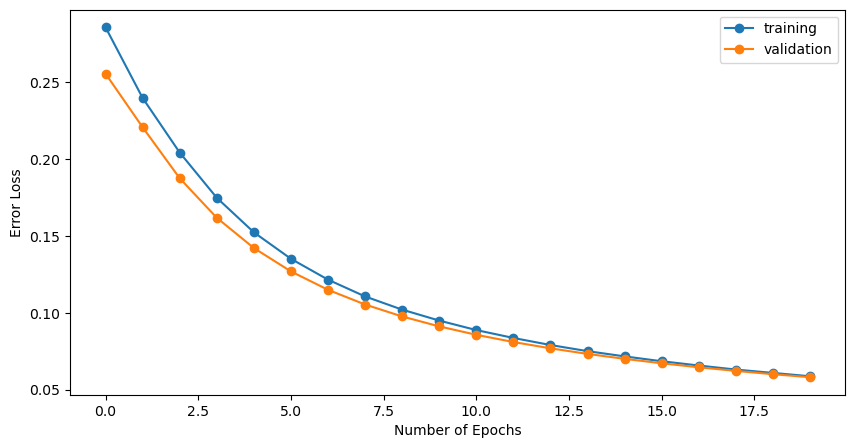

Trianing Recall Macro Curve


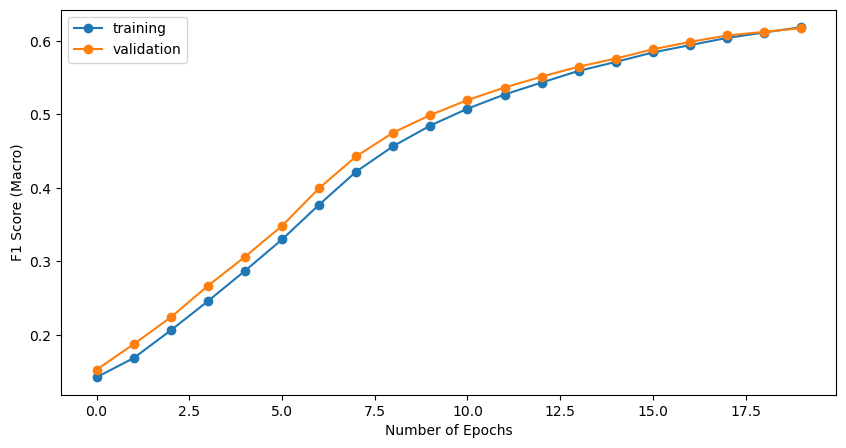

Recall (Macro)
0.6178455382381651
Unseen Class Labels
[10 16 18 25 27 28 29 32 33 35 39 42 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.79      0.56      0.65       400
         moose       0.46      0.79      0.58       554
humpback+whale       0.99      0.90      0.95       565
    chimpanzee       0.94      0.89      0.91       566
      squirrel       0.71      0.39      0.50       961
    rhinoceros       0.85      0.65      0.73       561
        rabbit       0.61      0.69      0.65       877
          wolf       0.54      0.89      0.67       470
     chihuahua       0.51      0.81      0.63       448
        weasel       0.11      0.57      0.19       222
   giant+panda       0.91      0.07      0.13       692
           pig       0.54      0.35      0.43       558
       raccoon       0.47      0.02      0.03       408

      accuracy                           0.57      7282
     macro avg       0.65      0.58      0.54      7282
  weighted avg       0.68      0.57      0.56      7282

Top_1_accuracy for UnSeen Validation split 01

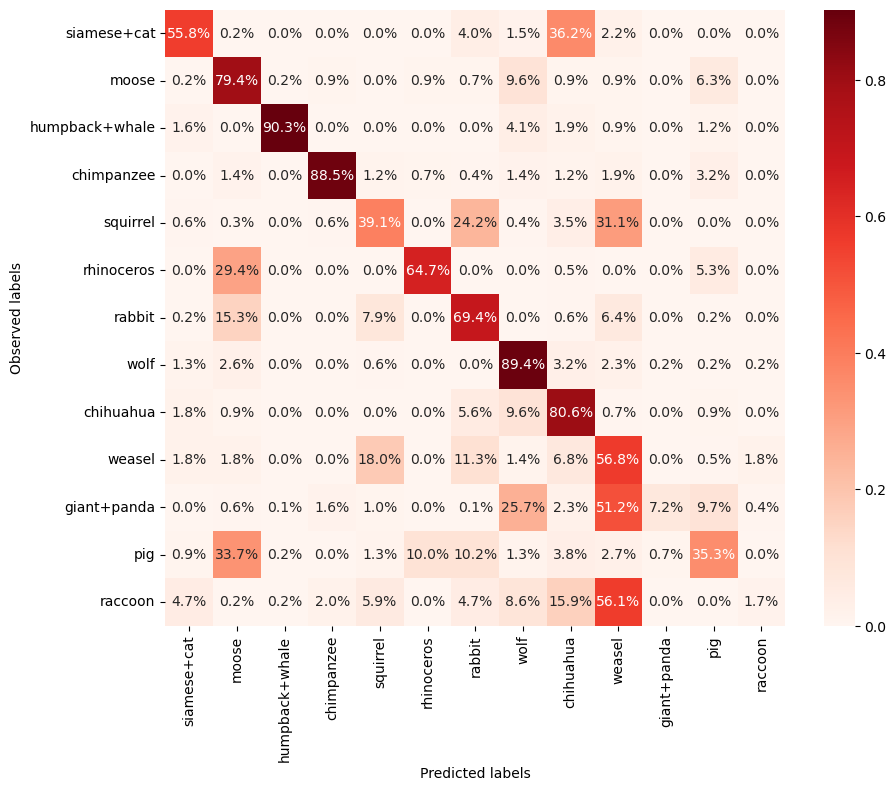

                precision    recall  f1-score   support

  ARTIODACTYLA       0.75      0.82      0.78      1677
     CARNIVORA       0.80      0.89      0.84      2640
    LAGOMORPHA       0.61      0.69      0.65       877
PERISSODACTYLA       0.85      0.65      0.73       561
      PRIMATES       0.94      0.89      0.91       566
      RODENTIA       0.71      0.39      0.50       961

      accuracy                           0.77      7282
     macro avg       0.78      0.72      0.74      7282
  weighted avg       0.77      0.77      0.76      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.82230173 0.89393939 0.69441277 0.64705882 0.88515901 0.39125911]
Top_1_accuracy for UnSeen Validation split 01 -  0.72235513887607


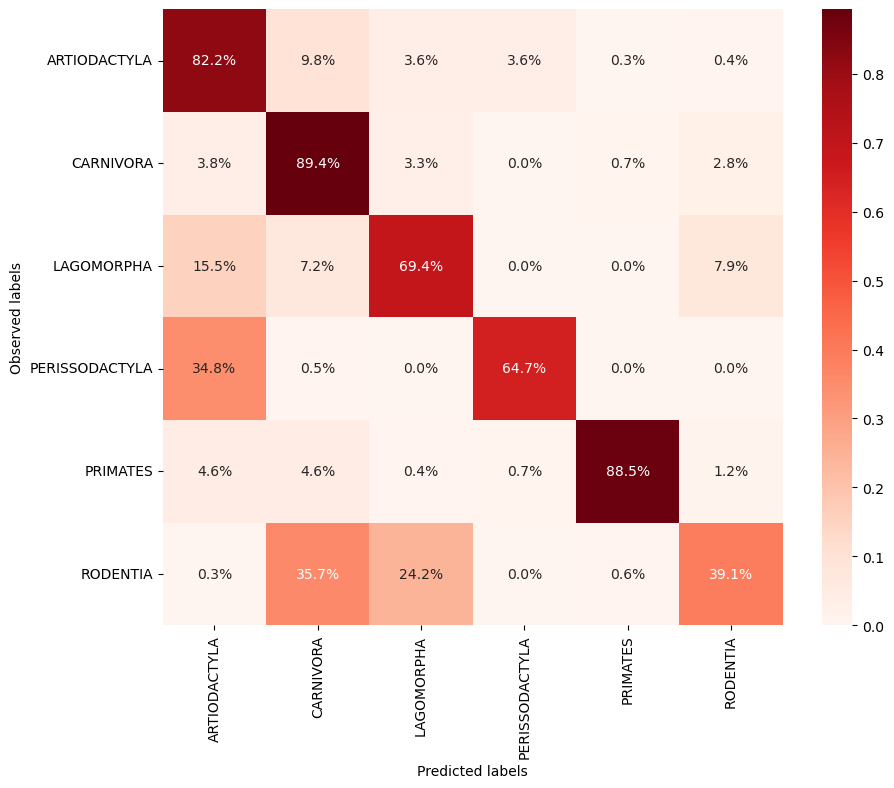

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.7422363886596266 
                 0         1
0      siamese+cat  0.845000
1            moose  0.850181
2   humpback+whale  0.916814
3       chimpanzee  0.906360
4         squirrel  0.694069
5       rhinoceros  0.791444
6           rabbit  0.940707
7             wolf  0.957447
8        chihuahua  0.955357
9           weasel  0.684685
10     giant+panda  0.177746
11             pig  0.772401
12         raccoon  0.156863 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.8251330068021415 
                 0         1
0      siamese+cat  0.930000
1            moose  0.891697
2   humpback+whale  0.927434
3       chimpanzee  0.922261
4         squirrel  0.759625
5       rhinoceros  0.992870
6           rabbit  0.969213
7             wolf  0.968085
8        chihuahua  0.982143
9           weasel  0.788288
10     giant+panda  0.328035
11             pig  0.860215
12         raccoon  0.406863 

 Top- 4  Accuracy per class 
 Top- 4  Accura

In [27]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 10. Hyperoptimisation

In [23]:
import argparse
import optuna
from optuna.integration import SkorchPruningCallback

class ProjectionNetwork_hyper(nn.Module):
    def __init__(self, trial: optuna.Trial):
        super(ProjectionNetwork_hyper, self).__init__()        
        layers = []
        n_layers = trial.suggest_int("n_layers", 1, 3)
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        input_dim = 2048
        for i in range(n_layers):
            output_dim = trial.suggest_int("n_units_l{}".format(i), 4, 2048, log=True)
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.Sigmoid())
            input_dim = output_dim
        
        layers.append(nn.Linear(input_dim, 213))

        self.model = nn.Sequential(*layers)
        print(self.model)  
        
                        
    def forward(self, x):
        out = self.model(x)
        return out   
    

def objective(trial: optuna.Trial):
    learning_rate = trial.suggest_loguniform('lr', .001, 1)
    bs = trial.suggest_int("batch_size", 4, 64)
    ep = trial.suggest_int("max_epoch", 5, 50)
    mom = trial.suggest_loguniform('optimizer__momentum', .90, .99)
   
       
    hyper_net1 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net2 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net3 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    #Split 1
    X1= X_train1.astype(np.float32).values
    y1 = y_train1.astype(np.float32).values
    hyper_net1.fit(X1, y1)
    #predict attributes for Unseen classes 
    y_pred_unseen1 = hyper_net1.predict_proba(ValData01.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob1 = []
    for y in y_pred_unseen1:
        y_pred_unseen_prob1.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL1 = predicate_df[predicate_df['classes'].isin((ValData01.classes.unique()).tolist())]
    animal_attributes1 = np.array(predicatedf_CZSL1.iloc[:,2:-18])
    animal_attributes_labels1 = predicatedf_CZSL1['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosine Distance           
    dist_CZSL1= (1-distance.cdist(y_pred_unseen_prob1, animal_attributes1, 'cosine'))        
    CZSL_label_prediction1 = np.array([np.argmax(output) for output in dist_CZSL1])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction1 = np.select([CZSL_label_prediction1 == 0, CZSL_label_prediction1 == 1, CZSL_label_prediction1 == 2, CZSL_label_prediction1 == 3
          , CZSL_label_prediction1 == 4, CZSL_label_prediction1 == 5, CZSL_label_prediction1 == 6, CZSL_label_prediction1 == 7
          , CZSL_label_prediction1 == 8, CZSL_label_prediction1 == 9, CZSL_label_prediction1 == 10, CZSL_label_prediction1 == 11
          , CZSL_label_prediction1 == 12], [animal_attributes_labels1[0], animal_attributes_labels1[1], animal_attributes_labels1[2]
          , animal_attributes_labels1[3], animal_attributes_labels1[4], animal_attributes_labels1[5]
          , animal_attributes_labels1[6], animal_attributes_labels1[7], animal_attributes_labels1[8], animal_attributes_labels1[9]
          , animal_attributes_labels1[10], animal_attributes_labels1[11], animal_attributes_labels1[12]], CZSL_label_prediction1)
        
    recall_score1 = recall_score(ValData01['labels'], CZSL_label_prediction1, average = 'macro')
    
    #Split 2
    X2= X_train2.astype(np.float32).values
    y2 = y_train2.astype(np.float32).values
    hyper_net2.fit(X2, y2)
    #predict attributes for Unseen classes 
    y_pred_unseen2 = hyper_net2.predict_proba(ValData02.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob2 = []
    for y in y_pred_unseen2:
        y_pred_unseen_prob2.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL2 = predicate_df[predicate_df['classes'].isin((ValData02.classes.unique()).tolist())]
    animal_attributes2 = np.array(predicatedf_CZSL2.iloc[:,2:-18])
    animal_attributes_labels2 = predicatedf_CZSL2['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL2= (1-distance.cdist(y_pred_unseen_prob2, animal_attributes2, 'cosine'))        
    CZSL_label_prediction2 = np.array([np.argmax(output) for output in dist_CZSL2])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction2 = np.select([CZSL_label_prediction2 == 0, CZSL_label_prediction2 == 1, CZSL_label_prediction2 == 2, CZSL_label_prediction2 == 3
          , CZSL_label_prediction2 == 4, CZSL_label_prediction2 == 5, CZSL_label_prediction2 == 6, CZSL_label_prediction2 == 7
          , CZSL_label_prediction2 == 8, CZSL_label_prediction2 == 9, CZSL_label_prediction2 == 10, CZSL_label_prediction2 == 11
          , CZSL_label_prediction2 == 12], [animal_attributes_labels2[0], animal_attributes_labels2[1], animal_attributes_labels2[2]
          , animal_attributes_labels2[3], animal_attributes_labels2[4], animal_attributes_labels2[5]
          , animal_attributes_labels2[6], animal_attributes_labels2[7], animal_attributes_labels2[8], animal_attributes_labels2[9]
          , animal_attributes_labels2[10], animal_attributes_labels2[11], animal_attributes_labels2[12]], CZSL_label_prediction2)
        
    recall_score2 = recall_score(ValData02['labels'], CZSL_label_prediction2, average = 'macro')
   
    #Split 3
    X3= X_train3.astype(np.float32).values
    y3 = y_train3.astype(np.float32).values
    hyper_net3.fit(X3, y3)
    #predict attributes for Unseen classes 
    y_pred_unseen3 = hyper_net3.predict_proba(ValData03.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob3 = []
    for y in y_pred_unseen3:
        y_pred_unseen_prob3.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL3 = predicate_df[predicate_df['classes'].isin((ValData03.classes.unique()).tolist())]
    animal_attributes3 = np.array(predicatedf_CZSL3.iloc[:,2:-18])
    animal_attributes_labels3 = predicatedf_CZSL3['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL3= (1-distance.cdist(y_pred_unseen_prob3, animal_attributes3, 'cosine'))        
    CZSL_label_prediction3 = np.array([np.argmax(output) for output in dist_CZSL3])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction3 = np.select([CZSL_label_prediction3 == 0, CZSL_label_prediction3 == 1, CZSL_label_prediction3 == 2, CZSL_label_prediction3 == 3
          , CZSL_label_prediction3 == 4, CZSL_label_prediction3 == 5, CZSL_label_prediction3 == 6, CZSL_label_prediction3 == 7
          , CZSL_label_prediction3 == 8, CZSL_label_prediction3 == 9, CZSL_label_prediction3 == 10, CZSL_label_prediction3 == 11
          , CZSL_label_prediction3 == 12], [animal_attributes_labels3[0], animal_attributes_labels3[1], animal_attributes_labels3[2]
          , animal_attributes_labels3[3], animal_attributes_labels3[4], animal_attributes_labels3[5]
          , animal_attributes_labels3[6], animal_attributes_labels3[7], animal_attributes_labels3[8], animal_attributes_labels3[9]
          , animal_attributes_labels3[10], animal_attributes_labels3[11], animal_attributes_labels3[12]], CZSL_label_prediction3)
        
    recall_score3 = recall_score(ValData03['labels'], CZSL_label_prediction3, average = 'macro')
    
    results = [recall_score1,recall_score2,recall_score3]
    print(results)
    #hyper_net.set_params(verbose=0)

    return np.mean(results)

In [24]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="skorch example.")
    parser.add_argument(
        "--pruning",
        "-p",
        action="store_true",
        help="Activate the pruning feature. `MedianPruner` stops unpromising "
        "trials at the early stages of training.",
    )
    args, unknown = parser.parse_known_args()

    pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=100, timeout=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-10 02:10:17,860] A new study created in memory with name: no-name-c5b57783-c403-4e79-bb67-848b223e44d9


Sequential(
  (0): Linear(in_features=2048, out_features=540, bias=True)
  (1): Dropout(p=0.38259962898744637, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=540, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=540, bias=True)
  (1): Dropout(p=0.38259962898744637, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=540, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=540, bias=True)
  (1): Dropout(p=0.38259962898744637, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=540, out_features=213, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.2212        0.3456                0.7398  0.9321
      2        0.0869        0.2689                0.7604  0.7718
      3        0.0596        0.2349                0.7646  0.7830
      4        0.0470        0.1975                0.76

[I 2022-12-10 02:10:47,858] Trial 0 finished with value: 0.5526744054590534 and parameters: {'lr': 0.45144700290912176, 'batch_size': 46, 'max_epoch': 10, 'optimizer__momentum': 0.9827753354170514, 'n_layers': 1, 'dropout': 0.38259962898744637, 'n_units_l0': 540}. Best is trial 0 with value: 0.5526744054590534.


[0.4848811793194038, 0.5649724437292543, 0.608169593328502]
Sequential(
  (0): Linear(in_features=2048, out_features=198, bias=True)
  (1): Dropout(p=0.1014609026706602, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=198, out_features=307, bias=True)
  (4): Dropout(p=0.1014609026706602, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=307, out_features=10, bias=True)
  (7): Dropout(p=0.1014609026706602, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=10, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=198, bias=True)
  (1): Dropout(p=0.1014609026706602, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=198, out_features=307, bias=True)
  (4): Dropout(p=0.1014609026706602, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=307, out_features=10, bias=True)
  (7): Dropout(p=0.1014609026706602, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=10, out_features=213, bias=True)
)
Sequential(
  (0): L

[I 2022-12-10 02:12:11,772] Trial 1 finished with value: 0.12933822592470923 and parameters: {'lr': 0.26352181990603324, 'batch_size': 25, 'max_epoch': 15, 'optimizer__momentum': 0.9334336373479241, 'n_layers': 3, 'dropout': 0.1014609026706602, 'n_units_l0': 198, 'n_units_l1': 307, 'n_units_l2': 10}. Best is trial 0 with value: 0.5526744054590534.


[0.17202857462311172, 0.07692307692307693, 0.13906302622793906]
Sequential(
  (0): Linear(in_features=2048, out_features=223, bias=True)
  (1): Dropout(p=0.22345924932173886, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=223, out_features=4, bias=True)
  (4): Dropout(p=0.22345924932173886, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=111, bias=True)
  (7): Dropout(p=0.22345924932173886, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=111, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=223, bias=True)
  (1): Dropout(p=0.22345924932173886, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=223, out_features=4, bias=True)
  (4): Dropout(p=0.22345924932173886, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=111, bias=True)
  (7): Dropout(p=0.22345924932173886, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=111, out_features=213, bias=True)
)
Sequential(
  

[I 2022-12-10 02:13:27,616] Trial 2 finished with value: 0.3623953665485671 and parameters: {'lr': 0.6107299776635324, 'batch_size': 53, 'max_epoch': 23, 'optimizer__momentum': 0.9572079128029001, 'n_layers': 3, 'dropout': 0.22345924932173886, 'n_units_l0': 223, 'n_units_l1': 4, 'n_units_l2': 111}. Best is trial 0 with value: 0.5526744054590534.


[0.28947774495221873, 0.4044173023912198, 0.39329105230226263]
Sequential(
  (0): Linear(in_features=2048, out_features=5, bias=True)
  (1): Dropout(p=0.4967674110332212, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=5, out_features=85, bias=True)
  (4): Dropout(p=0.4967674110332212, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=85, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=5, bias=True)
  (1): Dropout(p=0.4967674110332212, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=5, out_features=85, bias=True)
  (4): Dropout(p=0.4967674110332212, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=85, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=5, bias=True)
  (1): Dropout(p=0.4967674110332212, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=5, out_features=85, bias=True)
  (4): Dropout(p=0.4967674110332212, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_

     27        0.2255        0.2544                0.5938  6.0747
     28        0.2255        0.2592                0.5951  6.2519
     29        0.2247        0.2616                0.5870  6.5749
     30        0.2246        0.2647                0.5988  6.2451
     31        0.2249        0.2601                0.6027  6.4449
     32        0.2250        0.2626                0.5876  6.3929


[I 2022-12-10 02:24:11,523] Trial 3 finished with value: 0.21968792325836584 and parameters: {'lr': 0.1567485432930148, 'batch_size': 5, 'max_epoch': 32, 'optimizer__momentum': 0.9742440138208024, 'n_layers': 2, 'dropout': 0.4967674110332212, 'n_units_l0': 5, 'n_units_l1': 85}. Best is trial 0 with value: 0.5526744054590534.


[0.15471632439958233, 0.2807065774538805, 0.22364086792163468]
Sequential(
  (0): Linear(in_features=2048, out_features=15, bias=True)
  (1): Dropout(p=0.19803464908312482, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=15, out_features=4, bias=True)
  (4): Dropout(p=0.19803464908312482, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=15, bias=True)
  (1): Dropout(p=0.19803464908312482, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=15, out_features=4, bias=True)
  (4): Dropout(p=0.19803464908312482, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=15, bias=True)
  (1): Dropout(p=0.19803464908312482, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=15, out_features=4, bias=True)
  (4): Dropout(p=0.19803464908312482, inplace=False)
  (5): Sigmoid()
  (6): Lin

      5        0.2765        0.2757                0.1315  0.7116
      6        0.2761        0.2756                0.1315  0.8263
      7        0.2759        0.2754                0.1362  0.7288
      8        0.2757        0.2754                0.1315  0.6139
      9        0.2756        0.2753                0.1362  0.6964
     10        0.2754        0.2752                0.1362  0.7561
     11        0.2754        0.2752                0.1362  0.6975
     12        0.2753        0.2752                0.1362  0.7220
     13        0.2751        0.2751                0.1362  0.7450
     14        0.2751        0.2751                0.1315  0.7854
     15        0.2750        0.2751                0.1362  0.7286
     16        0.2750        0.2750                0.1315  0.6718
     17        0.2750        0.2750                0.1315  0.6679
     18        0.2750        0.2750                0.1362  0.7364
     19        0.2749        0.2750                0.1315  0.6611
     20   

[I 2022-12-10 02:25:50,501] Trial 4 finished with value: 0.09604956070122365 and parameters: {'lr': 0.3547629171670001, 'batch_size': 56, 'max_epoch': 40, 'optimizer__momentum': 0.9539131598248504, 'n_layers': 2, 'dropout': 0.19803464908312482, 'n_units_l0': 15, 'n_units_l1': 4}. Best is trial 0 with value: 0.5526744054590534.


[0.07692307692307693, 0.07692307692307693, 0.13430252825751712]
Sequential(
  (0): Linear(in_features=2048, out_features=8, bias=True)
  (1): Dropout(p=0.4091432251562226, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=8, out_features=19, bias=True)
  (4): Dropout(p=0.4091432251562226, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=19, out_features=81, bias=True)
  (7): Dropout(p=0.4091432251562226, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=81, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=8, bias=True)
  (1): Dropout(p=0.4091432251562226, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=8, out_features=19, bias=True)
  (4): Dropout(p=0.4091432251562226, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=19, out_features=81, bias=True)
  (7): Dropout(p=0.4091432251562226, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=81, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in

     10        0.2750        0.2749                0.1323  3.1913
     11        0.2749        0.2748                0.1327  3.2918
     12        0.2748        0.2747                0.1341  4.0732
     13        0.2747        0.2746                0.1340  4.2777
     14        0.2747        0.2745                0.1335  4.4532
     15        0.2746        0.2744                0.1352  3.2797
     16        0.2745        0.2743                0.1352  3.1745
     17        0.2744        0.2742                0.1354  3.2027
     18        0.2744        0.2742                0.1356  3.2045
     19        0.2743        0.2741                0.1354  3.3767
     20        0.2743        0.2740                0.1355  3.3296
     21        0.2742        0.2739                0.1356  3.3118
     22        0.2742        0.2738                0.1357  3.3766
     23        0.2741        0.2737                0.1355  3.4916
     24        0.2740        0.2736                0.1357  3.3994
     25   

[I 2022-12-10 02:32:00,066] Trial 5 finished with value: 0.07692307692307693 and parameters: {'lr': 0.007619027240149496, 'batch_size': 6, 'max_epoch': 33, 'optimizer__momentum': 0.903131182608282, 'n_layers': 3, 'dropout': 0.4091432251562226, 'n_units_l0': 8, 'n_units_l1': 19, 'n_units_l2': 81}. Best is trial 0 with value: 0.5526744054590534.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Number of finished trials: 6
Best trial:
  Value: 0.5526744054590534
  Params: 
    lr: 0.45144700290912176
    batch_size: 46
    max_epoch: 10
    optimizer__momentum: 0.9827753354170514
    n_layers: 1
    dropout: 0.38259962898744637
    n_units_l0: 540


# 11. Retrain with best parameters on three train val splits

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.7111                0.5015        0.7001                0.5069     +  0.9192
      2        0.7011                0.4993        0.6930                0.5053     +  0.8814
      3        0.6942                0.4959        0.6879                0.5035     +  0.8548
      4        0.6895                0.4896        0.6839                0.5026     +  0.7574
      5        0.6856                0.4859        0.6804                0.5015     +  0.7110
      6        0.6820                0.4813        0.6772                0.5002     +  0.7934
      7        0.6790                0.4761        0.6742                0.4961     +  0.8083
      8        0.6761                0.4696        0.6712                0.4925     +  0.7779
      9        0.6732                0.4658    

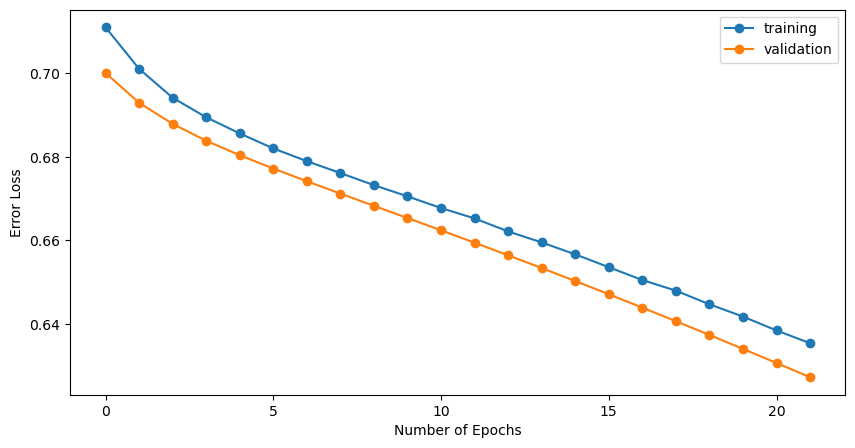

Trianing Recall Macro Curve


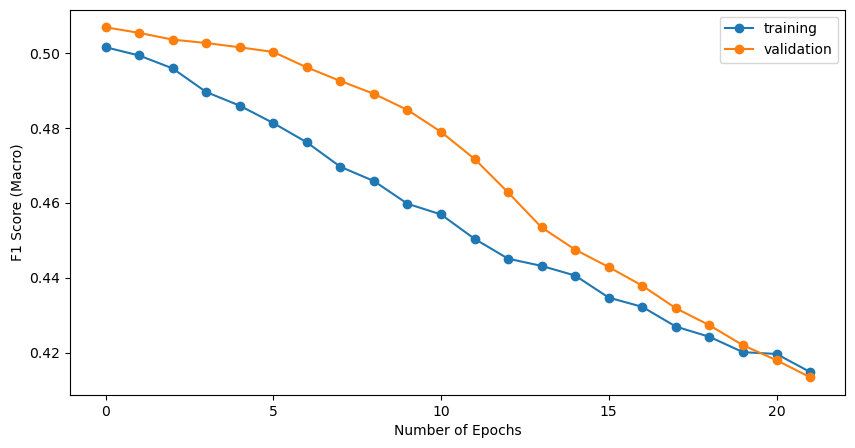

              precision    recall  f1-score   support

       black       0.61      0.70      0.65       882
       white       0.66      0.21      0.32       678
        blue       0.16      0.28      0.21       117
       brown       0.59      1.00      0.74       950
        gray       0.46      1.00      0.63       739
      orange       0.00      0.00      0.00       124
         red       0.00      0.00      0.00        54
      yellow       0.00      0.00      0.00        82
     patches       0.00      0.00      0.00       390
       spots       0.00      0.00      0.00       187
     stripes       0.14      0.94      0.24       180
       furry       0.80      1.00      0.89      1288
    hairless       0.20      1.00      0.34       331
   toughskin       0.51      1.00      0.68       826
         big       0.73      1.00      0.85      1188
       small       0.32      1.00      0.48       512
     bulbous       0.00      0.00      0.00       863
        lean       0.52    

alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.00      0.00      0.00       152
   dalmatian       0.03      0.22      0.05       442
        mole       0.00      0.00      0.00        75
     leopard       0.24      0.08      0.12       568
       moose       1.00      0.00      0.00       554
     gorilla       0.00      0.00      0.00       709
          ox       0.00      0.00      0.00       588
  chimpanzee       0.07      0.51      0.13       566
     hamster       0.00      0.00      0.00       640
      rabbit       0.00      0.00      0.00       877
 giant+panda       0.00      0.00      0.00       692
        deer       0.00      0.00      0.00      1069
     raccoon       0.00      0.00      0.00       408

    accuracy                           0.06      7340
   macro avg       0.10      0.06      0.02      7340
weighted avg       0.10      0.06      0.02      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.219457

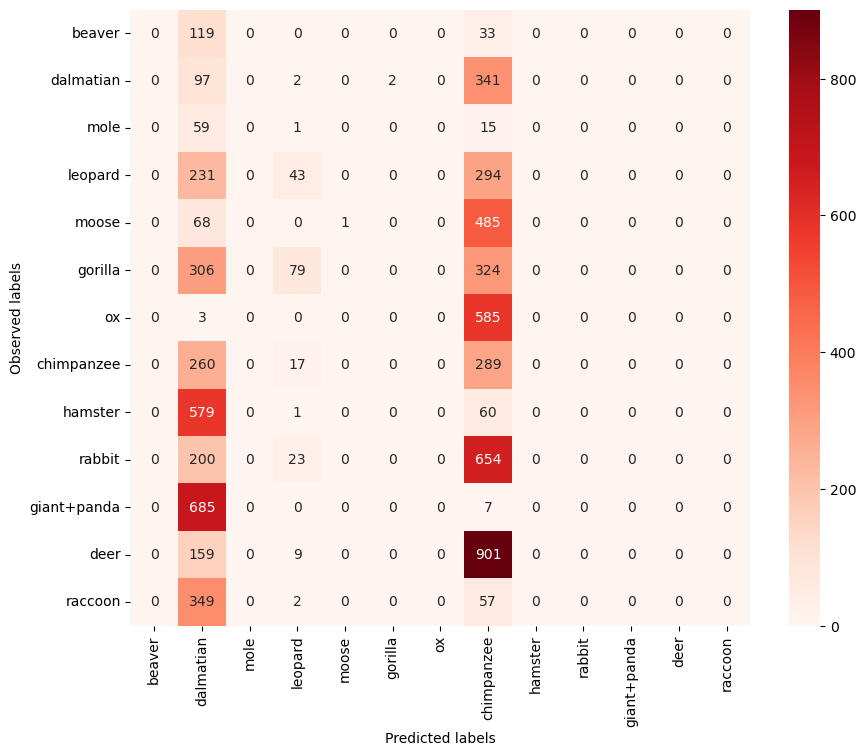

              precision    recall  f1-score   support

ARTIODACTYLA       1.00      0.00      0.00      2211
   CARNIVORA       0.43      0.67      0.52      2110
EULIPOTYPHLA       0.00      0.00      0.00        75
  LAGOMORPHA       0.00      0.00      0.00       877
    PRIMATES       0.15      0.48      0.23      1275
    RODENTIA       0.00      0.00      0.00       792

    accuracy                           0.28      7340
   macro avg       0.26      0.19      0.13      7340
weighted avg       0.45      0.28      0.19      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [4.52284034e-04 6.67772512e-01 0.00000000e+00 0.00000000e+00
 4.80784314e-01 0.00000000e+00]
Top_1_accuracy for UnSeen Validation split 01 -  0.19150151826803416


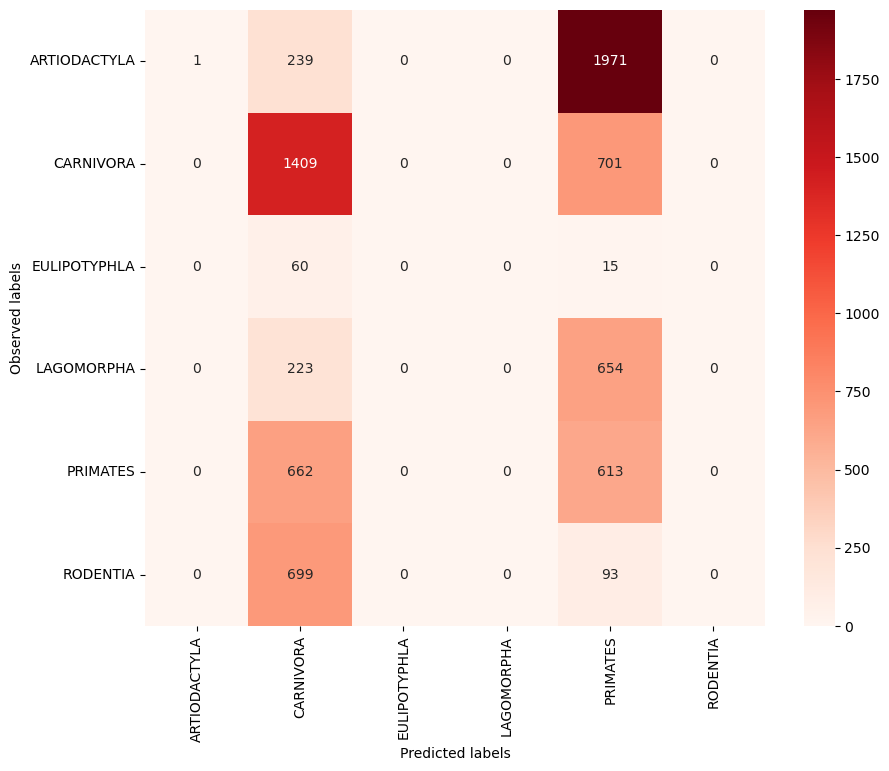

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.1565437836922806 
              0         1
0        beaver  0.000000
1     dalmatian  0.635747
2          mole  0.000000
3       leopard  0.338028
4         moose  0.016245
5       gorilla  0.025388
6            ox  0.000000
7    chimpanzee  0.840989
8       hamster  0.000000
9        rabbit  0.000000
10  giant+panda  0.000000
11         deer  0.178672
12      raccoon  0.000000 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.23830930371037012 
              0         1
0        beaver  0.006579
1     dalmatian  0.864253
2          mole  0.000000
3       leopard  0.647887
4         moose  0.054152
5       gorilla  0.349788
6            ox  0.005102
7    chimpanzee  0.936396
8       hamster  0.000000
9        rabbit  0.000000
10  giant+panda  0.000000
11         deer  0.233863
12      raccoon  0.000000 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.3285822345992421 
              0         1
0        beaver  0.019737
1    

In [56]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 10, 
               bs = 46, 
               numunits = 540, 
               lr = 0.45144700290912176, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.38259962898744637, 
               mom = 0.9827753354170514, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5445                0.3168        0.4938                0.3222     +  0.8245
      2        0.4891                0.3228        0.4811                0.3261     +  0.6902
      3        0.4807                0.3271        0.4746                0.3275     +  0.6925
      4        0.4745                0.3317        0.4686                0.3292     +  0.7121
      5        0.4684                0.3373        0.4624                0.3324     +  0.7034
      6        0.4618                0.3432        0.4557                0.3384     +  0.7769
      7        0.4550                0.3504        0.4484                0.3458     +  0.6591
      8        0.4473                0.3595        0.4406                0.3558     +  0.6921
      9        0.4391                0.3693    

     63        0.1899                0.7755        0.1862                0.7792     +  0.6366
     64        0.1880                0.7785        0.1845                0.7823     +  0.6493
     65        0.1865                0.7816        0.1829                0.7852     +  0.7258
     66        0.1850                0.7841        0.1813                0.7884     +  0.7248
     67        0.1833                0.7879        0.1797                0.7916     +  0.7004
     68        0.1821                0.7903        0.1782                0.7946     +  0.6733
     69        0.1805                0.7929        0.1767                0.7972     +  0.7488
     70        0.1790                0.7951        0.1752                0.8009     +  0.6965
     71        0.1774                0.7985        0.1738                0.8033     +  0.7728
     72        0.1762                0.8006        0.1724                0.8057     +  0.6734
     73        0.1748                0.8022        0.1710   

    127        0.1255                0.8739        0.1226                0.8763     +  0.6733
    128        0.1251                0.8741        0.1220                0.8768     +  0.6682
    129        0.1243                0.8756        0.1214                0.8776     +  0.6859
    130        0.1238                0.8758        0.1208                0.8782     +  0.6589
    131        0.1232                0.8753        0.1202                0.8787     +  0.6627
    132        0.1228                0.8771        0.1197                0.8794     +  0.6334
    133        0.1221                0.8778        0.1191                0.8800     +  0.6806
    134        0.1217                0.8785        0.1186                0.8811     +  0.7132
    135        0.1210                0.8797        0.1181                0.8818     +  0.6833
    136        0.1207                0.8796        0.1175                0.8823     +  0.7905
    137        0.1198                0.8803        0.1170   

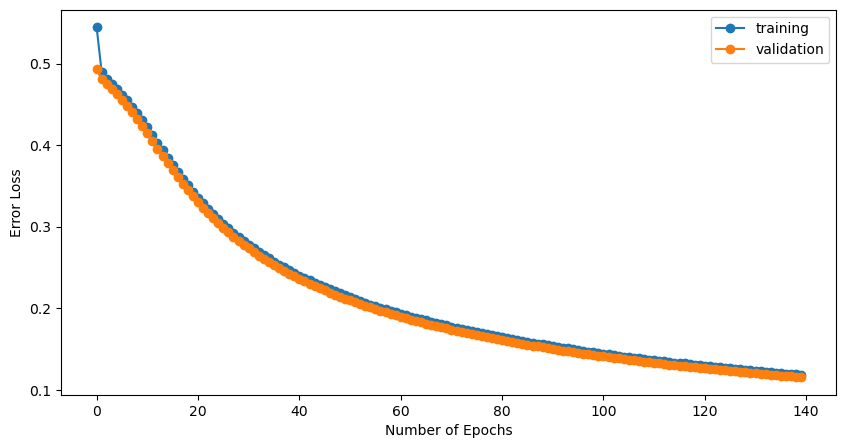

Trianing Recall Macro Curve


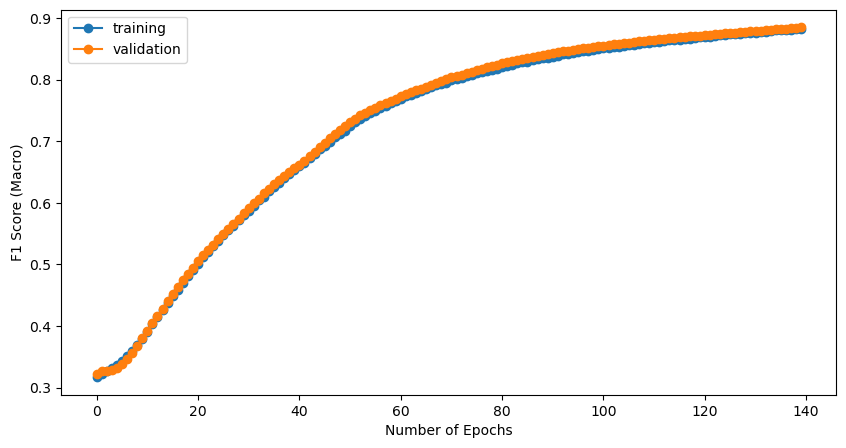

              precision    recall  f1-score   support

       black       0.91      0.94      0.92       974
       white       0.91      0.89      0.90       691
        blue       1.00      1.00      1.00        57
       brown       0.96      0.99      0.98      1173
        gray       0.94      0.91      0.92       778
      orange       1.00      0.96      0.98        70
         red       0.00      0.00      0.00         0
      yellow       1.00      0.94      0.97       139
     patches       0.92      0.95      0.94       737
       spots       0.94      0.81      0.87       382
     stripes       0.99      0.60      0.75       111
       furry       0.99      1.00      0.99      1421
    hairless       1.00      0.94      0.97       252
   toughskin       0.97      0.95      0.96       681
         big       0.98      0.99      0.99      1276
       small       0.96      0.91      0.94       535
     bulbous       0.94      0.94      0.94       934
        lean       0.89    

alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.69      0.98      0.81       864
grizzly+bear       0.82      0.70      0.76       690
killer+whale       0.88      0.69      0.78       231
      beaver       0.38      0.05      0.09       152
   dalmatian       0.33      0.72      0.45       442
 persian+cat       0.18      0.07      0.10       599
       skunk       0.15      0.22      0.18       157
          ox       0.39      0.89      0.54       588
         fox       0.64      0.81      0.71       540
   chihuahua       0.25      0.51      0.34       448
       otter       1.00      0.00      0.01       592
       zebra       0.98      0.23      0.37       942
         pig       0.09      0.04      0.05       558

    accuracy                           0.49      6803
   macro avg       0.52      0.45      0.40      6803
weighted avg       0.58      0.49      0.43      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.97569444 0.701449

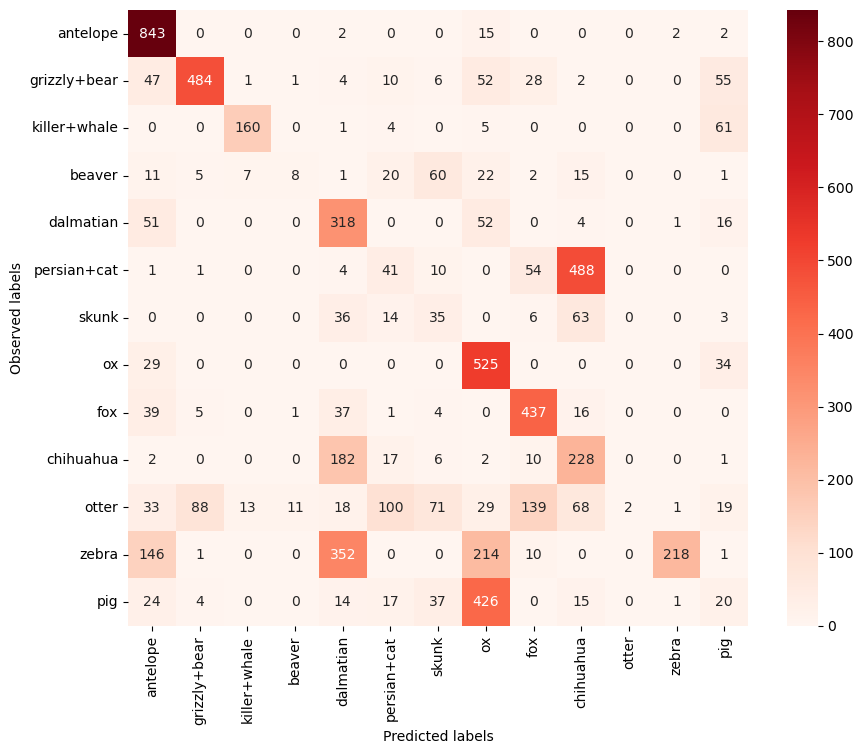

                precision    recall  f1-score   support

  ARTIODACTYLA       0.72      0.96      0.82      2241
     CARNIVORA       0.84      0.88      0.86      3468
PERISSODACTYLA       0.98      0.23      0.37       942
      RODENTIA       0.38      0.05      0.09       152

      accuracy                           0.79      6803
     macro avg       0.73      0.53      0.54      6803
  weighted avg       0.81      0.79      0.76      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.95671575 0.87572088 0.23142251 0.05263158]
Top_1_accuracy for UnSeen Validation split 01 -  0.529122678184407


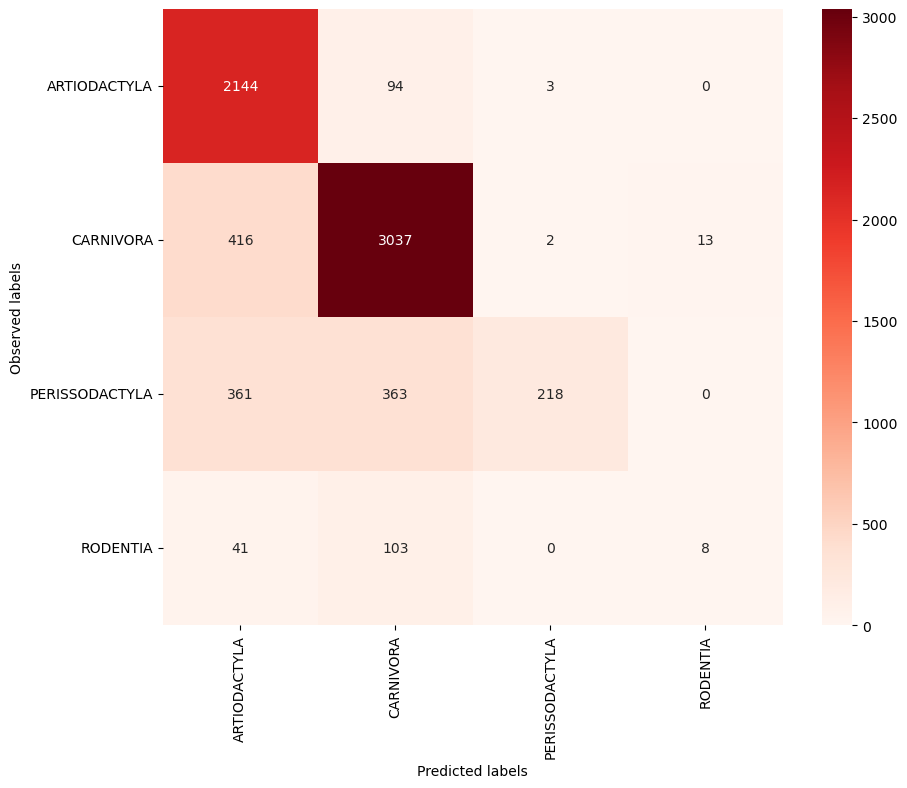

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6708474131262032 
               0         1
0       antelope  0.983796
1   grizzly+bear  0.742029
2   killer+whale  0.714286
3         beaver  0.138158
4      dalmatian  0.825792
5    persian+cat  0.585977
6          skunk  0.382166
7             ox  1.000000
8            fox  0.874074
9      chihuahua  0.953125
10         otter  0.045608
11         zebra  0.748408
12           pig  0.727599 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7518219019020724 
               0         1
0       antelope  0.998843
1   grizzly+bear  0.805797
2   killer+whale  0.727273
3         beaver  0.223684
4      dalmatian  0.959276
5    persian+cat  0.819699
6          skunk  0.547771
7             ox  1.000000
8            fox  0.931481
9      chihuahua  0.973214
10         otter  0.108108
11         zebra  0.857749
12           pig  0.820789 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8185146492012401 
               0         1
0  

In [49]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 140, 
               bs = 44, 
               numunits = 725, 
               lr = 0.01672300858684881, 
               optimiser = nn.Sigmoid(), 
               dropout = .25897885389379416, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = 'Deterministic', 
               dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5339                0.3022        0.4796                0.3121     +  0.8308
      2        0.4743                0.3092        0.4657                0.3234     +  0.6406
      3        0.4652                0.3157        0.4590                0.3267     +  0.6696
      4        0.4589                0.3212        0.4530                0.3302     +  0.6722
      5        0.4530                0.3266        0.4470                0.3340     +  0.6404
      6        0.4467                0.3337        0.4406                0.3387     +  0.6083
      7        0.4401                0.3403        0.4337                0.3444     +  0.6544
      8        0.4330                0.3490        0.4263                0.3522     +  0.6491
      9        0.4253                0.3579    

     63        0.1857                0.7154        0.1821                0.7244     +  0.6337
     64        0.1840                0.7196        0.1804                0.7283     +  0.6513
     65        0.1824                0.7232        0.1787                0.7323     +  0.6354
     66        0.1806                0.7273        0.1771                0.7355     +  0.6583
     67        0.1790                0.7311        0.1755                0.7384     +  0.6606
     68        0.1775                0.7337        0.1739                0.7413     +  0.6298
     69        0.1758                0.7386        0.1724                0.7443     +  0.6585
     70        0.1743                0.7411        0.1709                0.7472     +  0.6160
     71        0.1731                0.7432        0.1694                0.7500     +  0.6019
     72        0.1715                0.7478        0.1680                0.7525     +  0.6098
     73        0.1701                0.7505        0.1666   

    127        0.1190                0.8597        0.1168                0.8599     +  0.6385
    128        0.1187                0.8602        0.1162                0.8616     +  0.7042
    129        0.1180                0.8614        0.1156                0.8631     +  0.6390
    130        0.1171                0.8626        0.1150                0.8635     +  0.6600
    131        0.1165                0.8642        0.1144                0.8649     +  0.6648
    132        0.1161                0.8644        0.1138                0.8656     +  0.6420
    133        0.1155                0.8655        0.1133                0.8670     +  0.6468
    134        0.1150                0.8656        0.1127                0.8675     +  0.6472
    135        0.1145                0.8674        0.1122                0.8685     +  0.6994
    136        0.1139                0.8682        0.1116                0.8695     +  0.6327
    137        0.1133                0.8684        0.1111   

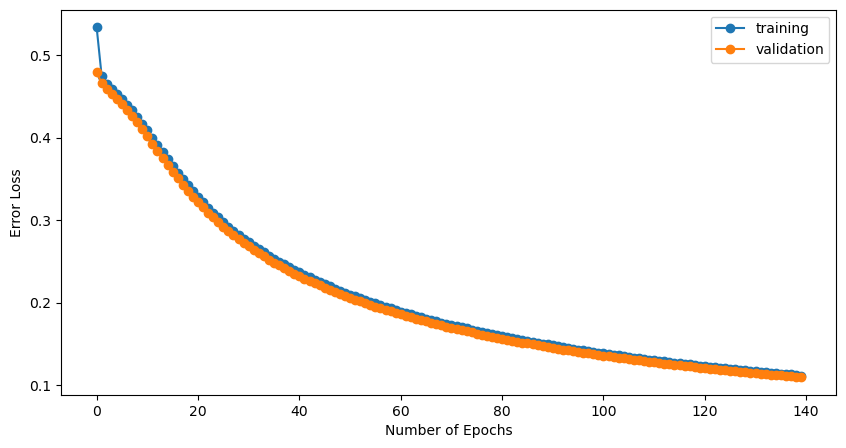

Trianing Recall Macro Curve


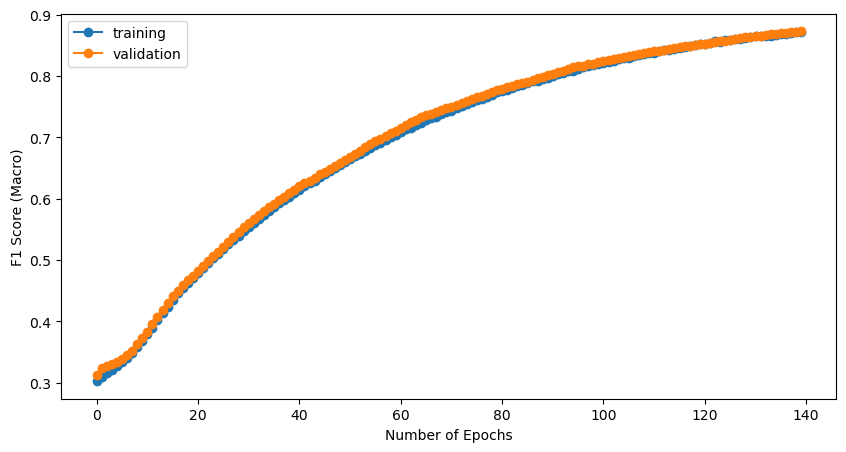

              precision    recall  f1-score   support

       black       0.92      0.95      0.93       918
       white       0.97      0.92      0.95       702
        blue       0.94      0.73      0.82        60
       brown       0.94      0.98      0.96      1025
        gray       0.92      0.79      0.85       451
      orange       0.97      0.85      0.91       124
         red       1.00      0.65      0.79        54
      yellow       1.00      0.88      0.94       139
     patches       0.91      0.85      0.88       566
       spots       0.88      0.71      0.78       339
     stripes       0.99      0.91      0.95       180
       furry       0.99      1.00      1.00      1463
    hairless       0.88      0.80      0.84       265
   toughskin       0.94      0.95      0.95       802
         big       0.98      0.99      0.98      1310
       small       0.95      0.89      0.92       396
     bulbous       0.95      0.97      0.96       911
        lean       0.96    

alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.42      0.69      0.52       400
         moose       0.48      0.77      0.59       554
humpback+whale       0.99      0.90      0.94       565
    chimpanzee       0.83      0.90      0.86       566
      squirrel       0.54      0.40      0.46       961
    rhinoceros       0.87      0.66      0.75       561
        rabbit       0.66      0.68      0.67       877
          wolf       0.62      0.74      0.67       470
     chihuahua       0.47      0.34      0.40       448
        weasel       0.07      0.41      0.12       222
   giant+panda       0.50      0.00      0.00       692
           pig       0.60      0.39      0.47       558
       raccoon       0.50      0.00      0.00       408

      accuracy                           0.53      7282
     macro avg       0.58      0.53      0.50      7282
  weighted avg       0.61      0.53      0.52      7282

Top_1_accuracy for UnSeen Validation split 01

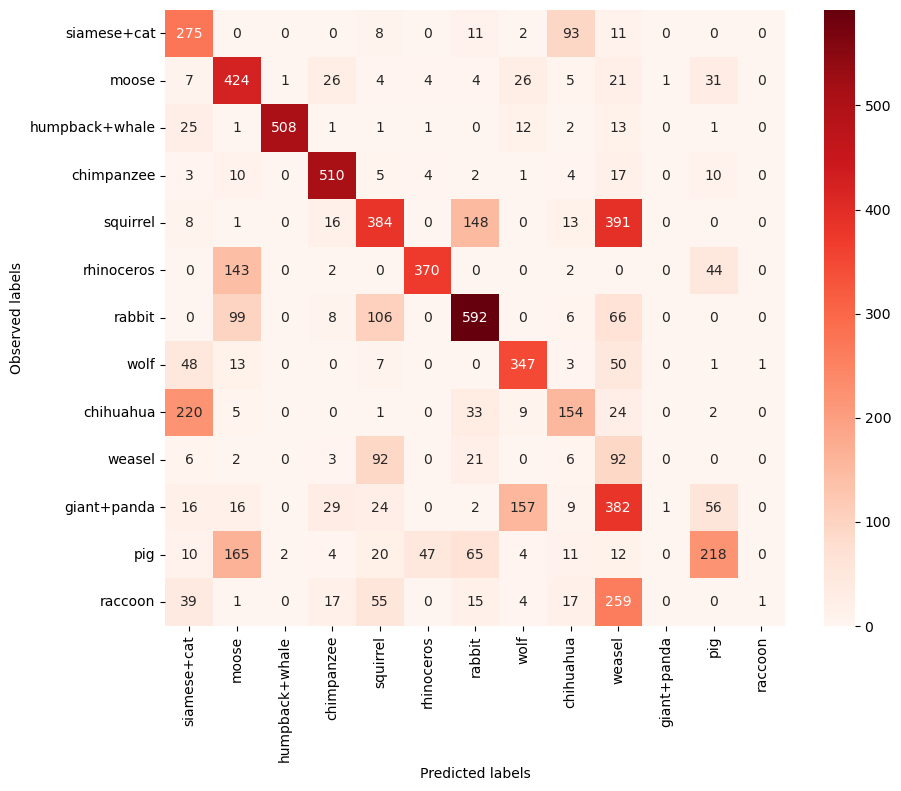

                precision    recall  f1-score   support

  ARTIODACTYLA       0.77      0.81      0.79      1677
     CARNIVORA       0.77      0.84      0.81      2640
    LAGOMORPHA       0.66      0.68      0.67       877
PERISSODACTYLA       0.87      0.66      0.75       561
      PRIMATES       0.83      0.90      0.86       566
      RODENTIA       0.54      0.40      0.46       961

      accuracy                           0.75      7282
     macro avg       0.74      0.71      0.72      7282
  weighted avg       0.74      0.75      0.74      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.80560525 0.84318182 0.67502851 0.65953654 0.90106007 0.39958377]
Top_1_accuracy for UnSeen Validation split 01 -  0.7139993252315401


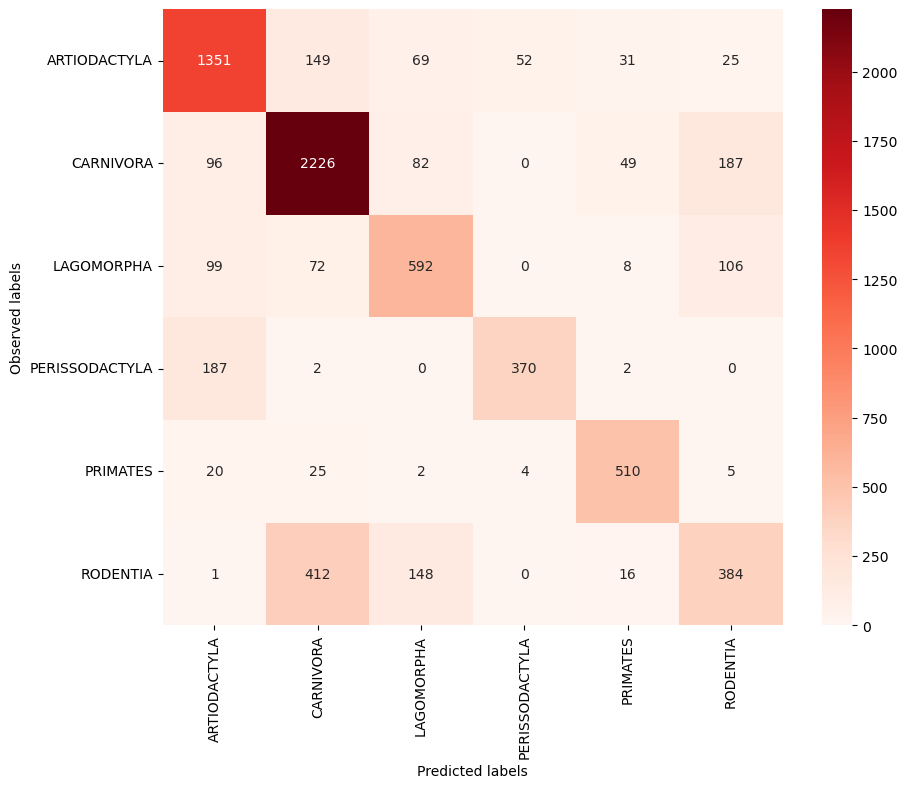

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.7118353984370991 
                 0         1
0      siamese+cat  0.907500
1            moose  0.842960
2   humpback+whale  0.916814
3       chimpanzee  0.922261
4         squirrel  0.826223
5       rhinoceros  0.823529
6           rabbit  0.838084
7             wolf  0.872340
8        chihuahua  0.848214
9           weasel  0.689189
10     giant+panda  0.005780
11             pig  0.716846
12         raccoon  0.044118 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7909887420457277 
                 0         1
0      siamese+cat  0.932500
1            moose  0.873646
2   humpback+whale  0.930973
3       chimpanzee  0.943463
4         squirrel  0.895942
5       rhinoceros  0.991087
6           rabbit  0.970353
7             wolf  0.902128
8        chihuahua  0.928571
9           weasel  0.869369
10     giant+panda  0.020231
11             pig  0.806452
12         raccoon  0.218137 

 Top- 4  Accuracy per class 
 Top- 4  Accura

In [53]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 140, 
               bs = 44, 
               numunits = 725, 
               lr = 0.01672300858684881, 
               optimiser = nn.Sigmoid(), 
               dropout = .25897885389379416, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = 'Deterministic', 
               dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 12. CZSL on Unseen Test Set

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.1542                0.4292        0.0596                0.6703     +  1.0651
      2        0.0582                0.6938        0.0388                0.7407     +  0.8402
      3        0.0439                0.7495        0.0320                0.7783     +  0.7939
      4        0.0363                0.7794        0.0285                0.7882     +  0.8526
      5        0.0316                0.7941        0.0268                0.7993     +  0.8763
      6        0.0278                0.8087        0.0259                0.8063     +  0.8029
      7        0.0253                0.8236        0.0248                0.8093     +  0.8241
      8        0.0229                0.8306        0.0239                0.8167     +  0.9063
      9        0.0214                0.8396    

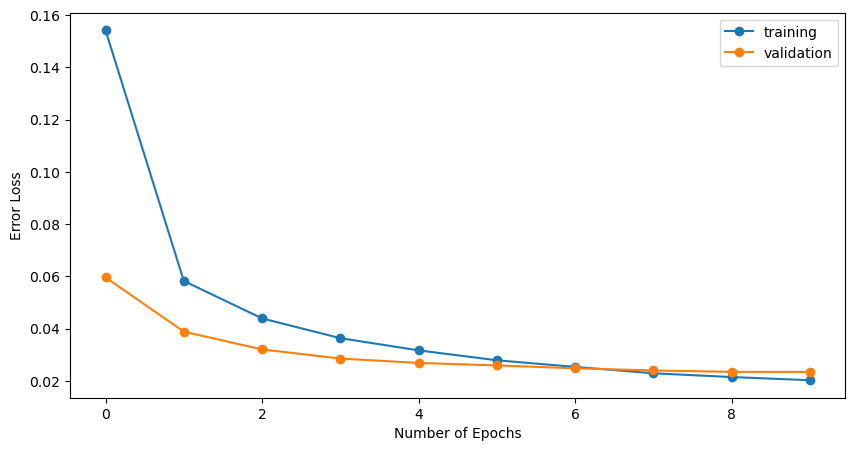

Trianing Recall Macro Curve


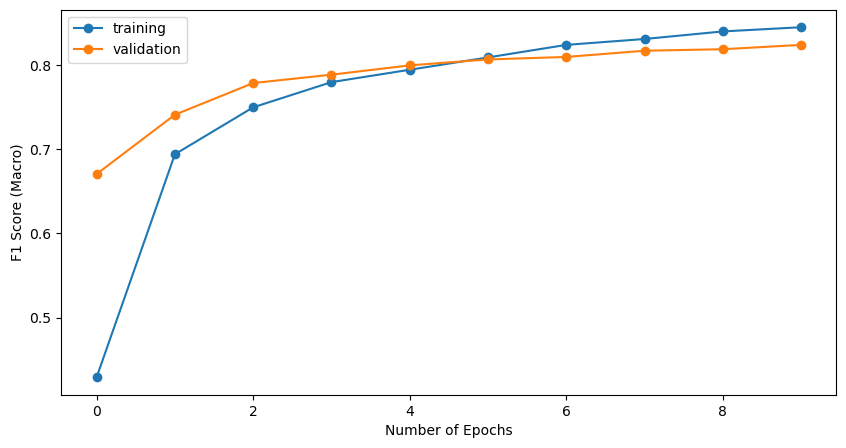

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.21      0.21      0.21      1645
  blue+whale       0.14      0.99      0.24       174
       sheep       0.39      0.40      0.39      1420
        seal       0.82      0.39      0.53       988
         bat       0.00      0.00      0.00       383
     giraffe       0.51      0.52      0.51      1202
         rat       0.52      0.95      0.67       310
      bobcat       0.73      0.95      0.82       630
      walrus       0.21      0.08      0.11       215
     dolphin       0.86      0.35      0.50       946

    accuracy                           0.42      7913
   macro avg       0.44      0.48      0.40      7913
weighted avg       0.48      0.42      0.42      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.21458967 0.99425287 0.39507042 0.38562753 0.         0.51996672
 0.95483871 0.94603175 0.07906977 0.35095137]
Top_1_accuracy for UnSeen Validation split 01 -  0.4840398811604295


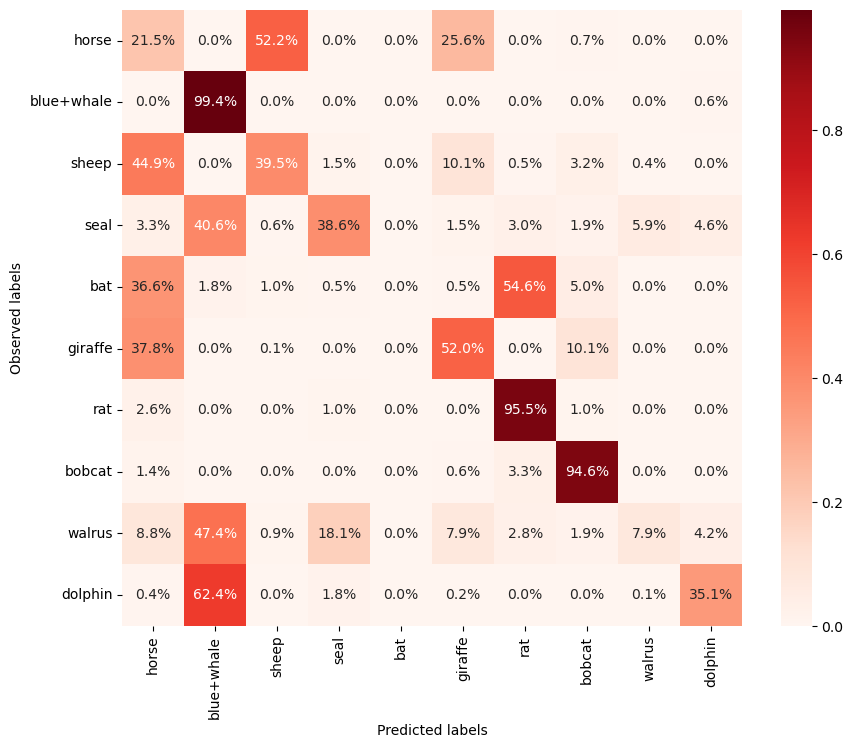

                precision    recall  f1-score   support

  ARTIODACTYLA       0.56      0.65      0.60      3742
     CARNIVORA       0.82      0.61      0.70      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.21      0.21      0.21      1645
      RODENTIA       0.52      0.95      0.67       310

      accuracy                           0.53      7913
     macro avg       0.42      0.49      0.44      7913
  weighted avg       0.52      0.53      0.52      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.64911812 0.60774686 0.         0.21458967 0.95483871]
Top_1_accuracy for UnSeen Validation split 01 -  0.48525867141001067


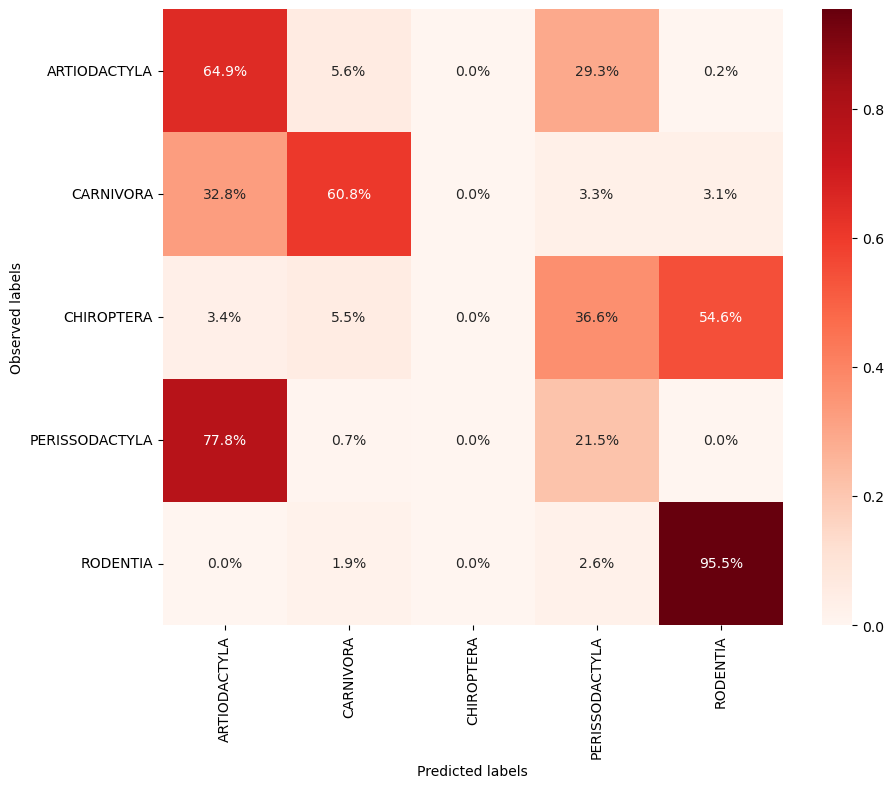

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.699518546806188 
            0         1
0       horse  0.413982
1  blue+whale  1.000000
2       sheep  0.733099
3        seal  0.508097
4         bat  0.086162
5     giraffe  0.847754
6         rat  0.980645
7      bobcat  0.973016
8      walrus  0.511628
9     dolphin  0.940803 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.83698481866482 
            0         1
0       horse  0.999392
1  blue+whale  1.000000
2       sheep  0.892254
3        seal  0.659919
4         bat  0.237598
5     giraffe  0.952579
6         rat  0.993548
7      bobcat  0.992063
8      walrus  0.660465
9     dolphin  0.982030 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.9319401100338028 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.911268
3        seal  0.917004
4         bat  0.684073
5     giraffe  0.988353
6         rat  0.993548
7      bobcat  0.996825
8      walrus  0.832558
9     dolphin  0.9957

In [26]:
Test = CZSL(mode = "Test", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 10, 
               bs = 46, 
               numunits = 540, 
               lr = 0.45144700290912176, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.38259962898744637, 
               mom = 0.9827753354170514, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4123                0.3986        0.3250                0.5152     +  2.2882
      2        0.2783                0.5973        0.2416                0.6715     +  2.0490
      3        0.2225                0.7084        0.2029                0.7497     +  2.2540
      4        0.1924                0.7649        0.1788                0.7909     +  2.1428
      5        0.1721                0.8015        0.1612                0.8236     +  2.0038
      6        0.1564                0.8281        0.1476                0.8467     +  2.1029
      7        0.1443                0.8475        0.1368                0.8643     +  2.1922
      8        0.1346                0.8622        0.1278                0.8761     +  2.0340
      9        0.1262                0.8741    

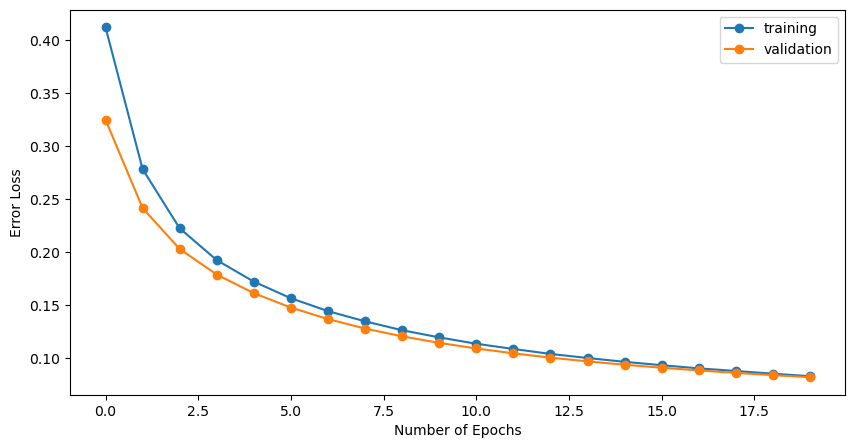

Trianing Recall Macro Curve


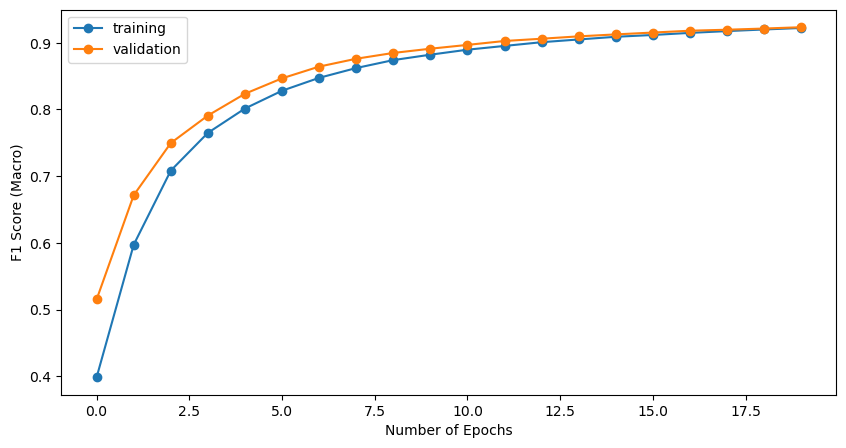

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes
[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.898930
[t-SNE] KL divergence after 1000 iterations: 0.250724


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.18      0.21      0.20      1645
  blue+whale       0.14      0.99      0.25       174
       sheep       0.43      0.70      0.53      1420
        seal       0.53      0.32      0.40       988
         bat       1.00      0.00      0.01       383
     giraffe       0.14      0.03      0.04      1202
         rat       0.41      0.86      0.55       310
      bobcat       0.80      0.83      0.81       630
      walrus       0.16      0.07      0.10       215
     dolphin       0.50      0.13      0.21       946

    accuracy                           0.35      7913
   macro avg       0.43      0.41      0.31      7913
weighted avg       0.40      0.35      0.31      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.21215805 0.99425287 0.70140845 0.31882591 0.00261097 0.02579035
 0.85806452 0.82857143 0.06976744 0.13424947]
Top_1_accuracy for UnSeen Validation split 01 -  0.41456994634046423


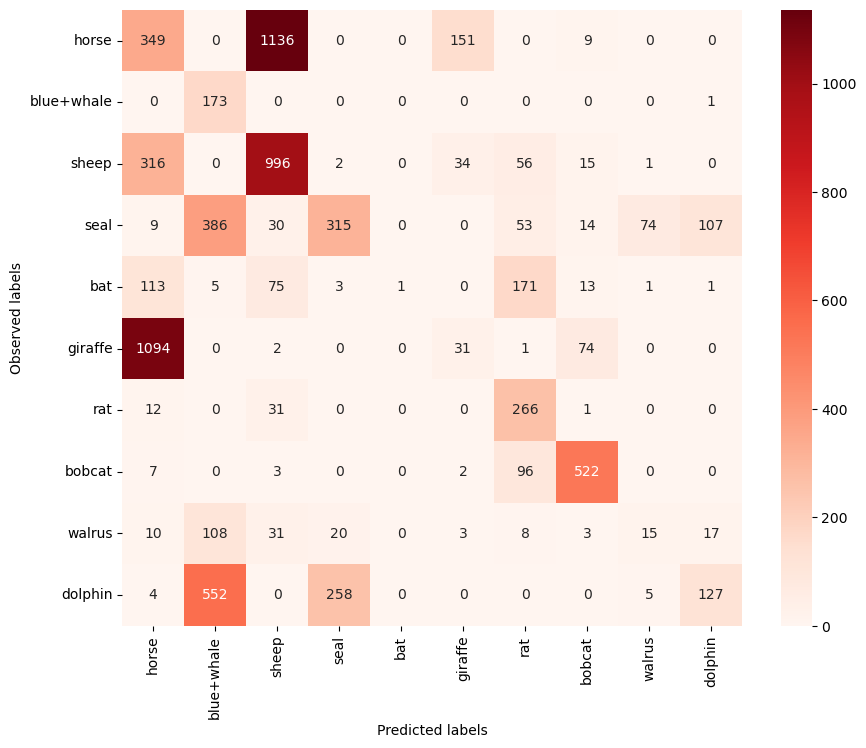

                precision    recall  f1-score   support

  ARTIODACTYLA       0.48      0.51      0.49      3742
     CARNIVORA       0.72      0.53      0.61      1833
    CHIROPTERA       1.00      0.00      0.01       383
PERISSODACTYLA       0.18      0.21      0.20      1645
      RODENTIA       0.41      0.86      0.55       310

      accuracy                           0.44      7913
     macro avg       0.56      0.42      0.37      7913
  weighted avg       0.49      0.44      0.44      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.51202565 0.52536825 0.00261097 0.21215805 0.85806452]
Top_1_accuracy for UnSeen Validation split 01 -  0.4220454880800629


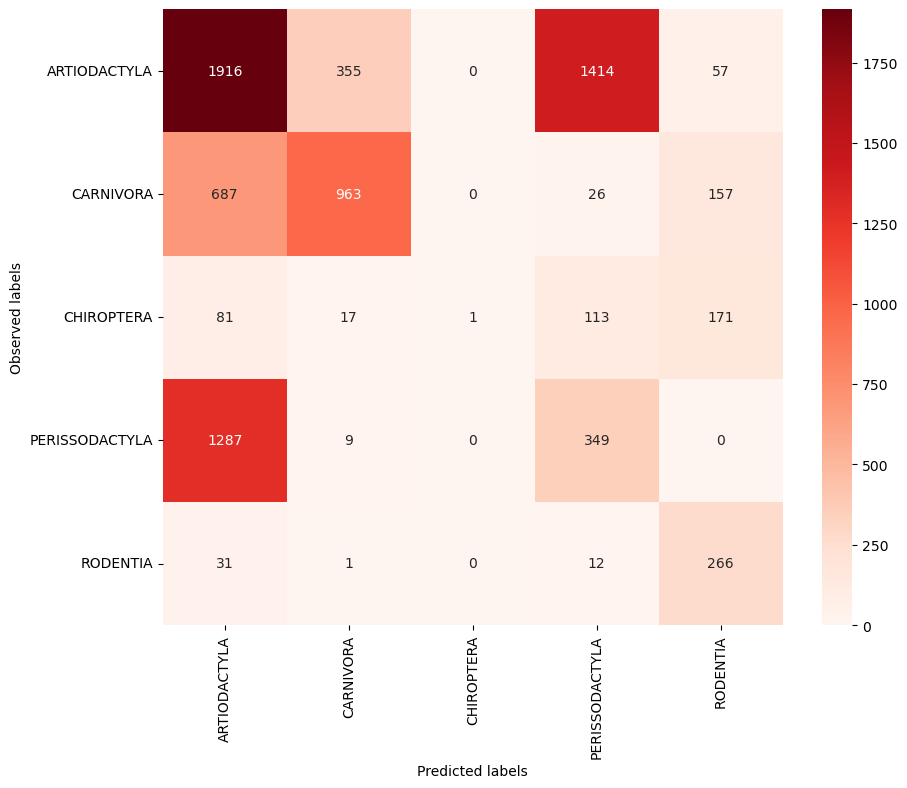

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6978563829335381 
            0         1
0       horse  0.782979
1  blue+whale  1.000000
2       sheep  0.877465
3        seal  0.493927
4         bat  0.026110
5     giraffe  0.897671
6         rat  0.925806
7      bobcat  0.977778
8      walrus  0.488372
9     dolphin  0.508457 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.8193325125212217 
            0         1
0       horse  0.998784
1  blue+whale  1.000000
2       sheep  0.954930
3        seal  0.696356
4         bat  0.101828
5     giraffe  0.948419
6         rat  0.993548
7      bobcat  0.988889
8      walrus  0.627907
9     dolphin  0.882664 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8978648633525801 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.981690
3        seal  0.880567
4         bat  0.284595
5     giraffe  0.997504
6         rat  0.996774
7      bobcat  0.992063
8      walrus  0.846512
9     dolphin  0.9

In [50]:
Test02 = CZSL(mode = "Test", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 13. Hyperoptimisation with best distance metric and prediction output type

In [28]:
import argparse
import optuna
from optuna.integration import SkorchPruningCallback

class ProjectionNetwork_hyper(nn.Module):
    def __init__(self, trial: optuna.Trial):
        super(ProjectionNetwork_hyper, self).__init__()        
        layers = []
        n_layers = trial.suggest_int("n_layers", 1, 3)
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        input_dim = 2048
        for i in range(n_layers):
            output_dim = trial.suggest_int("n_units_l{}".format(i), 4, 2048, log=True)
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.Sigmoid())
            input_dim = output_dim
        
        layers.append(nn.Linear(input_dim, 213))

        self.model = nn.Sequential(*layers)
        print(self.model)  
        
                        
    def forward(self, x):
        out = self.model(x)
        return out   
    

def objective(trial: optuna.Trial):
    learning_rate = trial.suggest_loguniform('lr', .001, 1)
    bs = trial.suggest_int("batch_size", 4, 64)
    ep = trial.suggest_int("max_epoch", 5, 50)
    mom = trial.suggest_loguniform('optimizer__momentum', .90, .99)
   
       
    hyper_net1 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net2 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net3 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    #Split 1
    X1= X_train1.astype(np.float32).values
    y1 = y_train1.astype(np.float32).values
    hyper_net1.fit(X1, y1)
    #predict attributes for Unseen classes 
    y_pred_unseen1 = hyper_net1.predict_proba(ValData01.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob1 = []
    for y in y_pred_unseen1:
        y_pred_unseen_prob1.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL1 = predicate_df[predicate_df['classes'].isin((ValData01.classes.unique()).tolist())]
    animal_attributes1 = np.array(predicatedf_CZSL1.iloc[:,2:-18])
    animal_attributes_labels1 = predicatedf_CZSL1['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosine Distance           
    dist_CZSL1= (1-distance.cdist(y_pred_unseen_prob1, animal_attributes1, 'cosine'))        
    CZSL_label_prediction1 = np.array([np.argmax(output) for output in dist_CZSL1])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction1 = np.select([CZSL_label_prediction1 == 0, CZSL_label_prediction1 == 1, CZSL_label_prediction1 == 2, CZSL_label_prediction1 == 3
          , CZSL_label_prediction1 == 4, CZSL_label_prediction1 == 5, CZSL_label_prediction1 == 6, CZSL_label_prediction1 == 7
          , CZSL_label_prediction1 == 8, CZSL_label_prediction1 == 9, CZSL_label_prediction1 == 10, CZSL_label_prediction1 == 11
          , CZSL_label_prediction1 == 12], [animal_attributes_labels1[0], animal_attributes_labels1[1], animal_attributes_labels1[2]
          , animal_attributes_labels1[3], animal_attributes_labels1[4], animal_attributes_labels1[5]
          , animal_attributes_labels1[6], animal_attributes_labels1[7], animal_attributes_labels1[8], animal_attributes_labels1[9]
          , animal_attributes_labels1[10], animal_attributes_labels1[11], animal_attributes_labels1[12]], CZSL_label_prediction1)
        
    recall_score1 = recall_score(ValData01['labels'], CZSL_label_prediction1, average = 'macro')
    
    #Split 2
    X2= X_train2.astype(np.float32).values
    y2 = y_train2.astype(np.float32).values
    hyper_net2.fit(X2, y2)
    #predict attributes for Unseen classes 
    y_pred_unseen2 = hyper_net2.predict_proba(ValData02.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob2 = []
    for y in y_pred_unseen2:
        y_pred_unseen_prob2.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL2 = predicate_df[predicate_df['classes'].isin((ValData02.classes.unique()).tolist())]
    animal_attributes2 = np.array(predicatedf_CZSL2.iloc[:,2:-18])
    animal_attributes_labels2 = predicatedf_CZSL2['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL2= (1-distance.cdist(y_pred_unseen_prob2, animal_attributes2, 'cosine'))        
    CZSL_label_prediction2 = np.array([np.argmax(output) for output in dist_CZSL2])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction2 = np.select([CZSL_label_prediction2 == 0, CZSL_label_prediction2 == 1, CZSL_label_prediction2 == 2, CZSL_label_prediction2 == 3
          , CZSL_label_prediction2 == 4, CZSL_label_prediction2 == 5, CZSL_label_prediction2 == 6, CZSL_label_prediction2 == 7
          , CZSL_label_prediction2 == 8, CZSL_label_prediction2 == 9, CZSL_label_prediction2 == 10, CZSL_label_prediction2 == 11
          , CZSL_label_prediction2 == 12], [animal_attributes_labels2[0], animal_attributes_labels2[1], animal_attributes_labels2[2]
          , animal_attributes_labels2[3], animal_attributes_labels2[4], animal_attributes_labels2[5]
          , animal_attributes_labels2[6], animal_attributes_labels2[7], animal_attributes_labels2[8], animal_attributes_labels2[9]
          , animal_attributes_labels2[10], animal_attributes_labels2[11], animal_attributes_labels2[12]], CZSL_label_prediction2)
        
    recall_score2 = recall_score(ValData02['labels'], CZSL_label_prediction2, average = 'macro')
   
    #Split 3
    X3= X_train3.astype(np.float32).values
    y3 = y_train3.astype(np.float32).values
    hyper_net3.fit(X3, y3)
    #predict attributes for Unseen classes 
    y_pred_unseen3 = hyper_net3.predict_proba(ValData03.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob3 = []
    for y in y_pred_unseen3:
        y_pred_unseen_prob3.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL3 = predicate_df[predicate_df['classes'].isin((ValData03.classes.unique()).tolist())]
    animal_attributes3 = np.array(predicatedf_CZSL3.iloc[:,2:-18])
    animal_attributes_labels3 = predicatedf_CZSL3['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL3= (1-distance.cdist(y_pred_unseen_prob3, animal_attributes3, 'cosine'))        
    CZSL_label_prediction3 = np.array([np.argmax(output) for output in dist_CZSL3])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction3 = np.select([CZSL_label_prediction3 == 0, CZSL_label_prediction3 == 1, CZSL_label_prediction3 == 2, CZSL_label_prediction3 == 3
          , CZSL_label_prediction3 == 4, CZSL_label_prediction3 == 5, CZSL_label_prediction3 == 6, CZSL_label_prediction3 == 7
          , CZSL_label_prediction3 == 8, CZSL_label_prediction3 == 9, CZSL_label_prediction3 == 10, CZSL_label_prediction3 == 11
          , CZSL_label_prediction3 == 12], [animal_attributes_labels3[0], animal_attributes_labels3[1], animal_attributes_labels3[2]
          , animal_attributes_labels3[3], animal_attributes_labels3[4], animal_attributes_labels3[5]
          , animal_attributes_labels3[6], animal_attributes_labels3[7], animal_attributes_labels3[8], animal_attributes_labels3[9]
          , animal_attributes_labels3[10], animal_attributes_labels3[11], animal_attributes_labels3[12]], CZSL_label_prediction3)
        
    recall_score3 = recall_score(ValData03['labels'], CZSL_label_prediction3, average = 'macro')
    
    results = [recall_score1,recall_score2,recall_score3]
    print(results)
    #hyper_net.set_params(verbose=0)

    return np.mean(results)

In [29]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="skorch example.")
    parser.add_argument(
        "--pruning",
        "-p",
        action="store_true",
        help="Activate the pruning feature. `MedianPruner` stops unpromising "
        "trials at the early stages of training.",
    )
    args, unknown = parser.parse_known_args()

    pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=100, timeout=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-10 03:05:46,953] A new study created in memory with name: no-name-405119d0-6412-4b83-a51b-dfef097406c1


Sequential(
  (0): Linear(in_features=2048, out_features=606, bias=True)
  (1): Dropout(p=0.3832039482727442, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=606, out_features=45, bias=True)
  (4): Dropout(p=0.3832039482727442, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=45, out_features=13, bias=True)
  (7): Dropout(p=0.3832039482727442, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=13, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=606, bias=True)
  (1): Dropout(p=0.3832039482727442, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=606, out_features=45, bias=True)
  (4): Dropout(p=0.3832039482727442, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=45, out_features=13, bias=True)
  (7): Dropout(p=0.3832039482727442, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=13, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=606, bias=True)
  (1): Drop

[I 2022-12-10 03:07:16,178] Trial 0 finished with value: 0.07692307692307693 and parameters: {'lr': 0.015056559357415407, 'batch_size': 22, 'max_epoch': 14, 'optimizer__momentum': 0.9134725501558436, 'n_layers': 3, 'dropout': 0.3832039482727442, 'n_units_l0': 606, 'n_units_l1': 45, 'n_units_l2': 13}. Best is trial 0 with value: 0.07692307692307693.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.4441098702431395, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=7, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.4441098702431395, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=7, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.4441098702431395, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=7, out_features=213, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.6846        0.6707                0.3571  1.1597
      2        0.6597        0.6421                0.3177  1.1783
      3        0.6315        0.6093                0.2659  1.2315
      

     26        0.3496        0.3190                0.1313  1.1252
     27        0.3461        0.3161                0.1314  1.1975
     28        0.3425        0.3135                0.1314  1.1705
     29        0.3395        0.3111                0.1314  1.1396
     30        0.3368        0.3089                0.1314  1.1222


[I 2022-12-10 03:09:14,212] Trial 1 finished with value: 0.07692307692307693 and parameters: {'lr': 0.0019194094346310134, 'batch_size': 27, 'max_epoch': 30, 'optimizer__momentum': 0.9298241009076554, 'n_layers': 1, 'dropout': 0.4441098702431395, 'n_units_l0': 7}. Best is trial 0 with value: 0.07692307692307693.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=281, bias=True)
  (1): Dropout(p=0.44072148305081427, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=281, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=281, bias=True)
  (1): Dropout(p=0.44072148305081427, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=281, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=281, bias=True)
  (1): Dropout(p=0.44072148305081427, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=281, out_features=213, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.4180        0.2857                0.1265  0.7097
      2        0.2827        0.2760                0.1309  0.6227
      3        0.2759        0.2712                0.1370

     36        0.1433        0.1206                0.4655  0.6421
     37        0.1411        0.1188                0.4790  0.6238
     38        0.1392        0.1170                0.4921  0.6542
     39        0.1371        0.1153                0.5044  0.6173
     40        0.1352        0.1137                0.5159  0.6399
     41        0.1333        0.1121                0.5263  0.6026
     42        0.1314        0.1105                0.5376  0.6178
     43        0.1297        0.1091                0.5468  0.6060
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.4133        0.2837                0.1384  0.6365
      2        0.2811        0.2740                0.1390  0.5735
      3        0.2742        0.2691                0.1416  0.6133
      4        0.2695        0.2638                0.1455  0.6141
      5        0.2646        0.2577                0.1508  0.6823
      6   

[I 2022-12-10 03:10:44,577] Trial 2 finished with value: 0.4404443739234251 and parameters: {'lr': 0.005479059677785874, 'batch_size': 59, 'max_epoch': 43, 'optimizer__momentum': 0.9634455524001205, 'n_layers': 1, 'dropout': 0.44072148305081427, 'n_units_l0': 281}. Best is trial 2 with value: 0.4404443739234251.


[0.4008126153116188, 0.43722608576905664, 0.4832944206895997]
Sequential(
  (0): Linear(in_features=2048, out_features=205, bias=True)
  (1): Dropout(p=0.19453019201722463, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=205, out_features=529, bias=True)
  (4): Dropout(p=0.19453019201722463, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=529, out_features=1687, bias=True)
  (7): Dropout(p=0.19453019201722463, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=1687, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=205, bias=True)
  (1): Dropout(p=0.19453019201722463, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=205, out_features=529, bias=True)
  (4): Dropout(p=0.19453019201722463, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=529, out_features=1687, bias=True)
  (7): Dropout(p=0.19453019201722463, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=1687, out_features=213, bias=True)
)
Sequ

     21        0.2740        0.2743                0.1315  2.1195
     22        0.2739        0.2742                0.1315  2.0544
     23        0.2739        0.2742                0.1315  2.0402
     24        0.2739        0.2742                0.1315  2.0941
     25        0.2738        0.2741                0.1315  2.2388
     26        0.2738        0.2741                0.1315  2.0831
     27        0.2737        0.2740                0.1315  2.0214
     28        0.2737        0.2740                0.1315  2.0063


[I 2022-12-10 03:13:54,321] Trial 3 finished with value: 0.07692307692307693 and parameters: {'lr': 0.0021905299191241154, 'batch_size': 18, 'max_epoch': 28, 'optimizer__momentum': 0.9712123260148513, 'n_layers': 3, 'dropout': 0.19453019201722463, 'n_units_l0': 205, 'n_units_l1': 529, 'n_units_l2': 1687}. Best is trial 2 with value: 0.4404443739234251.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=92, bias=True)
  (1): Dropout(p=0.24209602250748055, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=92, out_features=1239, bias=True)
  (4): Dropout(p=0.24209602250748055, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=1239, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=92, bias=True)
  (1): Dropout(p=0.24209602250748055, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=92, out_features=1239, bias=True)
  (4): Dropout(p=0.24209602250748055, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=1239, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=92, bias=True)
  (1): Dropout(p=0.24209602250748055, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=92, out_features=1239, bias=True)
  (4): Dropout(p=0.24209602250748055, inplace=False)
  (5): Sigm

[I 2022-12-10 03:15:10,554] Trial 4 finished with value: 0.4674953899324364 and parameters: {'lr': 0.8957211015410729, 'batch_size': 35, 'max_epoch': 22, 'optimizer__momentum': 0.9744790663423253, 'n_layers': 2, 'dropout': 0.24209602250748055, 'n_units_l0': 92, 'n_units_l1': 1239}. Best is trial 4 with value: 0.4674953899324364.


[0.4305171699564506, 0.4253311806606724, 0.5466378191801862]
Sequential(
  (0): Linear(in_features=2048, out_features=748, bias=True)
  (1): Dropout(p=0.3757160885234271, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=748, out_features=23, bias=True)
  (4): Dropout(p=0.3757160885234271, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=23, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=748, bias=True)
  (1): Dropout(p=0.3757160885234271, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=748, out_features=23, bias=True)
  (4): Dropout(p=0.3757160885234271, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=23, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=748, bias=True)
  (1): Dropout(p=0.3757160885234271, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=748, out_features=23, bias=True)
  (4): Dropout(p=0.3757160885234271, inplace=False)
  (5): Sigmoid()
  (6): 

     35        0.2449        0.2308                0.1924  0.5701
     36        0.2446        0.2301                0.1940  0.5849
     37        0.2440        0.2292                0.1949  0.5631
     38        0.2432        0.2285                0.1950  0.5899
     39        0.2429        0.2274                0.1955  0.5594
     40        0.2422        0.2263                0.1969  0.5631
     41        0.2416        0.2254                0.1975  0.5957
     42        0.2408        0.2243                0.1995  0.5580
     43        0.2395        0.2226                0.2011  0.5684
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.3873        0.2824                0.1362  0.5493
      2        0.2845        0.2796                0.1362  0.5676
      3        0.2799        0.2792                0.1362  0.6121
      4        0.2783        0.2790                0.1362  0.5549
      5   

[I 2022-12-10 03:16:36,569] Trial 5 finished with value: 0.202244556586322 and parameters: {'lr': 0.12280064321146403, 'batch_size': 61, 'max_epoch': 43, 'optimizer__momentum': 0.92489825461748, 'n_layers': 2, 'dropout': 0.3757160885234271, 'n_units_l0': 748, 'n_units_l1': 23}. Best is trial 4 with value: 0.4674953899324364.


[0.20890790994317635, 0.25899552944243004, 0.13883023037335965]
Sequential(
  (0): Linear(in_features=2048, out_features=49, bias=True)
  (1): Dropout(p=0.2869388357970917, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=49, out_features=1464, bias=True)
  (4): Dropout(p=0.2869388357970917, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=1464, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=49, bias=True)
  (1): Dropout(p=0.2869388357970917, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=49, out_features=1464, bias=True)
  (4): Dropout(p=0.2869388357970917, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=1464, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=49, bias=True)
  (1): Dropout(p=0.2869388357970917, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=49, out_features=1464, bias=True)
  (4): Dropout(p=0.2869388357970917, inplace=False)
  (5): Sigmoid()


[I 2022-12-10 03:17:11,473] Trial 6 finished with value: 0.07692307692307693 and parameters: {'lr': 0.002854451731191951, 'batch_size': 63, 'max_epoch': 18, 'optimizer__momentum': 0.9007949755278601, 'n_layers': 2, 'dropout': 0.2869388357970917, 'n_units_l0': 49, 'n_units_l1': 1464}. Best is trial 4 with value: 0.4674953899324364.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=447, bias=True)
  (1): Dropout(p=0.26919069610745244, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=447, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=447, bias=True)
  (1): Dropout(p=0.26919069610745244, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=447, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=447, bias=True)
  (1): Dropout(p=0.26919069610745244, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=447, out_features=213, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.0775        0.0394                0.7383  1.9504
      2        0.0265        0.0315                0.7569  1.9624
      3        0.0184        0.0299                0.7607

[I 2022-12-10 03:18:47,617] Trial 7 finished with value: 0.5692824628961586 and parameters: {'lr': 0.7021105747052101, 'batch_size': 11, 'max_epoch': 16, 'optimizer__momentum': 0.910874291255116, 'n_layers': 1, 'dropout': 0.26919069610745244, 'n_units_l0': 447}. Best is trial 7 with value: 0.5692824628961586.


[0.5204955871102318, 0.5580201317612311, 0.6293316698170129]
Sequential(
  (0): Linear(in_features=2048, out_features=18, bias=True)
  (1): Dropout(p=0.2620786859483758, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=18, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=18, bias=True)
  (1): Dropout(p=0.2620786859483758, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=18, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=18, bias=True)
  (1): Dropout(p=0.2620786859483758, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=18, out_features=213, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.6441        0.5771                0.2100  0.5365
      2        0.5322        0.4664                0.1417  0.5418
      3        0.4496        0.3996                0.1346  0.5370
   

     43        0.2751        0.2683                0.1422  0.5615
     44        0.2744        0.2676                0.1427  0.5815
     45        0.2737        0.2668                0.1433  0.5786
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.6718        0.6148                0.2684  0.5414
      2        0.5550        0.4775                0.1420  0.6332
      3        0.4507        0.3946                0.1272  0.5732
      4        0.3921        0.3521                0.1245  0.5264
      5        0.3589        0.3284                0.1302  0.5166
      6        0.3384        0.3137                0.1346  0.5003
      7        0.3248        0.3042                0.1360  0.5043
      8        0.3153        0.2977                0.1360  0.5801
      9        0.3083        0.2930                0.1362  0.5278
     10        0.3030        0.2895                0.1362  0.5447
     11   

[I 2022-12-10 03:20:13,341] Trial 8 finished with value: 0.11129522195309242 and parameters: {'lr': 0.003068554218967326, 'batch_size': 47, 'max_epoch': 45, 'optimizer__momentum': 0.9688214099686359, 'n_layers': 1, 'dropout': 0.2620786859483758, 'n_units_l0': 18}. Best is trial 7 with value: 0.5692824628961586.


[0.1442241583793067, 0.07705389848246992, 0.11260760899750069]
Sequential(
  (0): Linear(in_features=2048, out_features=403, bias=True)
  (1): Dropout(p=0.43437261274425965, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=403, out_features=14, bias=True)
  (4): Dropout(p=0.43437261274425965, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=14, out_features=663, bias=True)
  (7): Dropout(p=0.43437261274425965, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=663, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=403, bias=True)
  (1): Dropout(p=0.43437261274425965, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=403, out_features=14, bias=True)
  (4): Dropout(p=0.43437261274425965, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=14, out_features=663, bias=True)
  (7): Dropout(p=0.43437261274425965, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=663, out_features=213, bias=True)
)
Sequential(

      2        0.3418        0.3194                0.1315  0.8028
      3        0.3086        0.3008                0.1315  0.7852
      4        0.2959        0.2923                0.1353  0.7603
      5        0.2896        0.2877                0.1361  0.7844
      6        0.2859        0.2848                0.1361  0.7944
      7        0.2836        0.2829                0.1361  0.7750
      8        0.2819        0.2816                0.1361  0.7658
      9        0.2808        0.2806                0.1361  0.7700
     10        0.2799        0.2798                0.1361  0.7759
     11        0.2792        0.2792                0.1361  0.7670
     12        0.2787        0.2787                0.1361  0.7126
     13        0.2782        0.2783                0.1361  0.7212
     14        0.2778        0.2780                0.1361  0.7234
     15        0.2775        0.2777                0.1361  0.7511
     16        0.2773        0.2774                0.1361  0.8397
     17   

[I 2022-12-10 03:21:48,860] Trial 9 finished with value: 0.07692307692307693 and parameters: {'lr': 0.002639192639229026, 'batch_size': 52, 'max_epoch': 38, 'optimizer__momentum': 0.900298165488286, 'n_layers': 3, 'dropout': 0.43437261274425965, 'n_units_l0': 403, 'n_units_l1': 14, 'n_units_l2': 663}. Best is trial 7 with value: 0.5692824628961586.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=1877, bias=True)
  (1): Dropout(p=0.11052964070115001, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=1877, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=1877, bias=True)
  (1): Dropout(p=0.11052964070115001, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=1877, out_features=213, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=1877, bias=True)
  (1): Dropout(p=0.11052964070115001, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=1877, out_features=213, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.0474        0.0508                0.7504  7.7934
      2        0.0264        0.0596                0.7492  7.9325
      3        0.0259        0.0664                

[I 2022-12-10 03:24:53,460] Trial 10 finished with value: 0.5203420043680423 and parameters: {'lr': 0.9202568683588493, 'batch_size': 4, 'max_epoch': 10, 'optimizer__momentum': 0.9475968122673183, 'n_layers': 1, 'dropout': 0.11052964070115001, 'n_units_l0': 1877}. Best is trial 7 with value: 0.5692824628961586.


[0.4728709253697168, 0.5015940227362639, 0.5865610649981463]
Number of finished trials: 11
Best trial:
  Value: 0.5692824628961586
  Params: 
    lr: 0.7021105747052101
    batch_size: 11
    max_epoch: 16
    optimizer__momentum: 0.910874291255116
    n_layers: 1
    dropout: 0.26919069610745244
    n_units_l0: 447


Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.0695                0.5885        0.0308                0.7003     +  1.8569
      2        0.0244                0.7290        0.0238                0.7271     +  1.4592
      3        0.0168                0.7527        0.0216                0.7342     +  1.6953
      4        0.0130                0.7611        0.0201                0.7403     +  1.4943
      5        0.0102                0.7667        0.0195                0.7434     +  1.4059
      6        0.0084                0.7697        0.0194                0.7423     +  1.4572
      7        0.0068                0.7723        0.0193                0.7428     +  1.4108
      8        0.0057                0.7741        0.0195                0.7422        1.4068
      9        0.0049                0.7749    

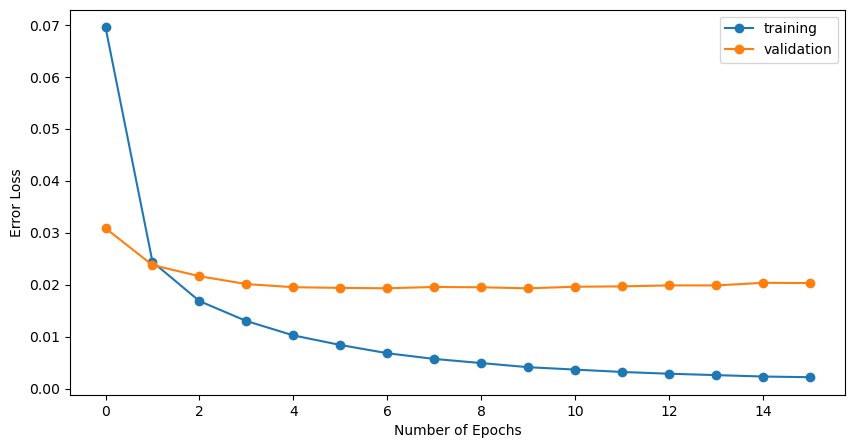

Trianing Recall Macro Curve


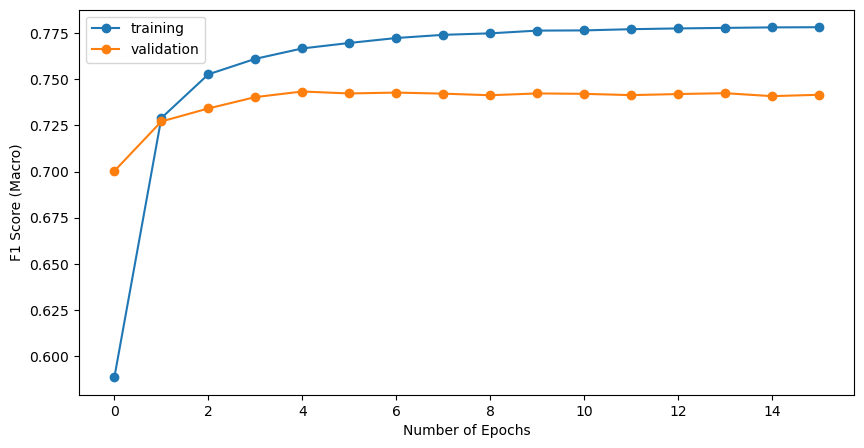

                              precision    recall  f1-score   support

                       black       0.97      0.98      0.98       882
                       white       0.97      0.97      0.97       678
                        blue       0.95      0.92      0.94       117
                       brown       0.98      0.98      0.98       950
                        gray       0.97      0.97      0.97       739
                      orange       0.98      0.98      0.98       124
                         red       0.96      0.96      0.96        54
                      yellow       0.99      0.99      0.99        82
                     patches       0.94      0.96      0.95       390
                       spots       0.97      0.94      0.95       187
                     stripes       1.00      0.98      0.99       180
                       furry       1.00      1.00      1.00      1288
                    hairless       0.99      0.98      0.98       331
                   

Unseen Class Labels
[ 4  5 12 15 16 20 21 25 26 29 39 40 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.81      0.58      0.68       152
   dalmatian       0.35      0.45      0.39       442
        mole       0.06      0.08      0.07        75
     leopard       0.64      0.96      0.77       568
       moose       0.70      0.24      0.35       554
     gorilla       0.77      0.07      0.13       709
          ox       0.48      1.00      0.65       588
  chimpanzee       0.42      0.66      0.51       566
     hamster       0.42      0.81      0.56       640
      rabbit       0.69      0.07      0.13       877
 giant+panda       0.81      0.24      0.37       692
        deer       0.92      0.86      0.89      1069
     raccoon       0.37      0.75      0.50       408

    accuracy                           0.54      7340
   macro avg       0.57      0.52      0.46      7340
weighted avg       0.64      0.54      0.48      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.57894737 0.450226

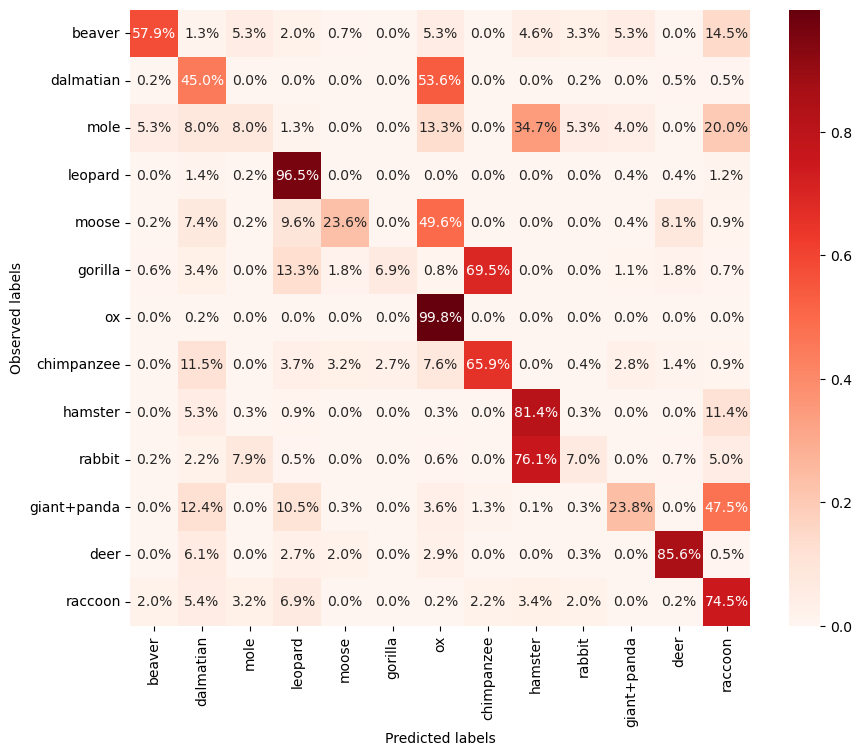

              precision    recall  f1-score   support

ARTIODACTYLA       0.83      0.91      0.87      2211
   CARNIVORA       0.72      0.84      0.78      2110
EULIPOTYPHLA       0.06      0.08      0.07        75
  LAGOMORPHA       0.69      0.07      0.13       877
    PRIMATES       0.98      0.73      0.84      1275
    RODENTIA       0.46      0.78      0.58       792

    accuracy                           0.73      7340
   macro avg       0.62      0.57      0.54      7340
weighted avg       0.76      0.73      0.71      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.90682949 0.84028436 0.08       0.0695553  0.72941176 0.77777778]
Top_1_accuracy for UnSeen Validation split 01 -  0.5673097822931252


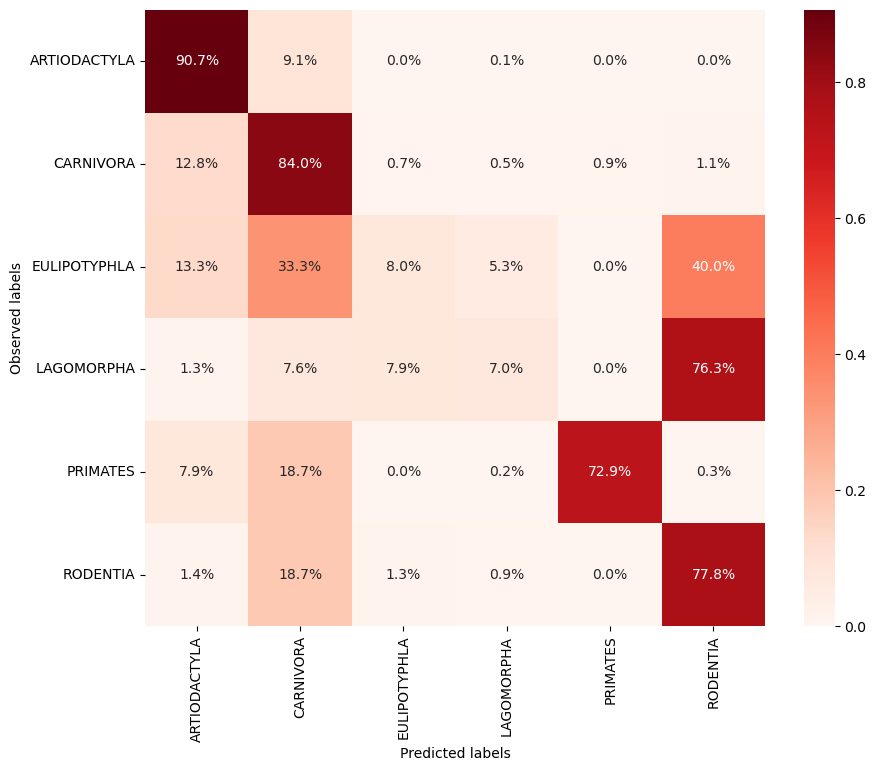

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.7056223616264231 
              0         1
0        beaver  0.644737
1     dalmatian  0.518100
2          mole  0.280000
3       leopard  0.975352
4         moose  0.801444
5       gorilla  0.748942
6            ox  1.000000
7    chimpanzee  0.724382
8       hamster  0.854688
9        rabbit  0.435576
10  giant+panda  0.414740
11         deer  0.895229
12      raccoon  0.879902 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7941566392899287 
              0         1
0        beaver  0.690789
1     dalmatian  0.556561
2          mole  0.666667
3       leopard  0.984155
4         moose  0.833935
5       gorilla  0.846262
6            ox  1.000000
7    chimpanzee  0.791519
8       hamster  0.917188
9        rabbit  0.592930
10  giant+panda  0.569364
11         deer  0.945744
12      raccoon  0.928922 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8854182473115959 
              0         1
0        beaver  0.776316
1     

In [42]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 16, 
               bs = 11, 
               numunits = 447, 
               lr = 0.7021105747052101, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.26919069610745244, 
               mom = 0.910874291255116, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.0690                0.6090        0.0280                0.7120     +  1.9513
      2        0.0248                0.7230        0.0217                0.7335     +  1.6479
      3        0.0178                0.7546        0.0194                0.7442     +  2.0125
      4        0.0138                0.7654        0.0185                0.7478     +  2.1469
      5        0.0109                0.7728        0.0183                0.7541     +  1.7107
      6        0.0088                0.7786        0.0182                0.7555     +  1.6698
      7        0.0073                0.7823        0.0180                0.7572     +  1.6556
      8        0.0063                0.7835        0.0183                0.7557        1.6291
      9        0.0052                0.7864    

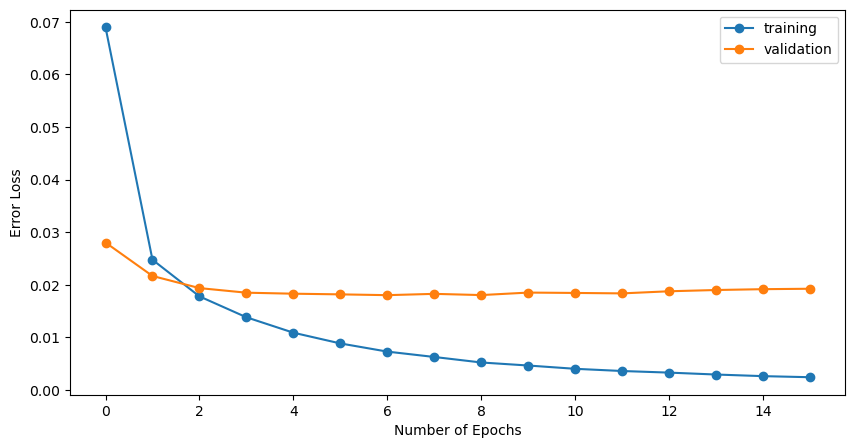

Trianing Recall Macro Curve


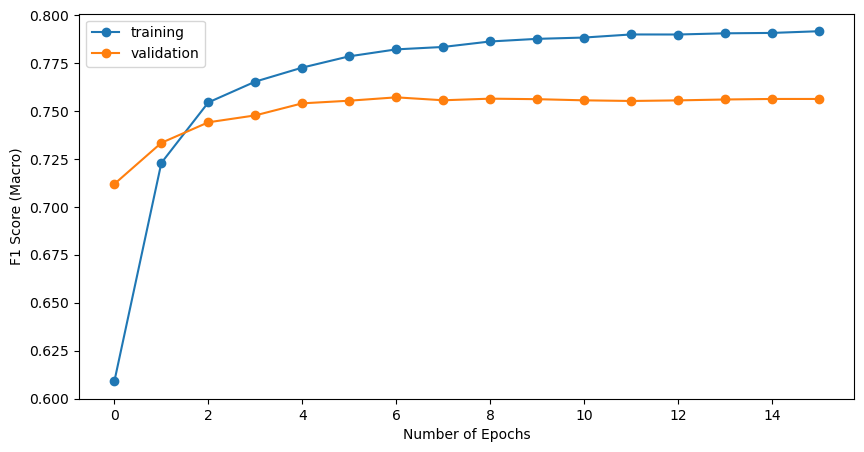

                              precision    recall  f1-score   support

                       black       0.99      0.97      0.98       974
                       white       0.98      0.95      0.97       691
                        blue       1.00      1.00      1.00        57
                       brown       0.99      1.00      0.99      1173
                        gray       0.99      0.98      0.98       778
                      orange       1.00      0.97      0.99        70
                         red       0.00      0.00      0.00         0
                      yellow       1.00      0.99      0.99       139
                     patches       0.97      0.99      0.98       737
                       spots       0.97      0.97      0.97       382
                     stripes       0.97      0.95      0.96       111
                       furry       1.00      1.00      1.00      1421
                    hairless       1.00      0.99      1.00       252
                   

Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.69      0.98      0.81       864
grizzly+bear       0.77      0.64      0.70       690
killer+whale       0.92      0.90      0.91       231
      beaver       0.21      0.02      0.04       152
   dalmatian       0.39      0.38      0.38       442
 persian+cat       0.87      0.78      0.82       599
       skunk       0.33      0.52      0.41       157
          ox       0.38      0.99      0.55       588
         fox       0.44      0.84      0.58       540
   chihuahua       0.68      0.62      0.65       448
       otter       1.00      0.00      0.01       592
       zebra       0.99      0.52      0.69       942
         pig       0.35      0.06      0.10       558

    accuracy                           0.60      6803
   macro avg       0.62      0.56      0.51      6803
weighted avg       0.68      0.60      0.55      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.97685185 0.636231

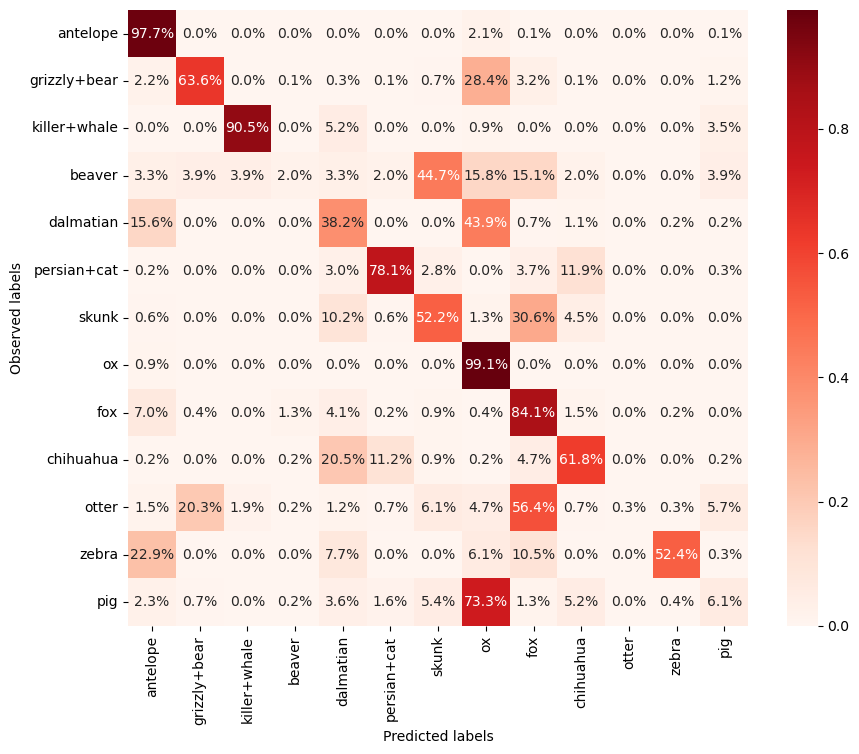

                precision    recall  f1-score   support

  ARTIODACTYLA       0.70      0.95      0.80      2241
     CARNIVORA       0.88      0.82      0.85      3468
PERISSODACTYLA       0.99      0.52      0.69       942
      RODENTIA       0.21      0.02      0.04       152

      accuracy                           0.80      6803
     macro avg       0.69      0.58      0.59      6803
  weighted avg       0.82      0.80      0.79      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.94868362 0.8189158  0.52441614 0.01973684]
Top_1_accuracy for UnSeen Validation split 01 -  0.5779381007458874


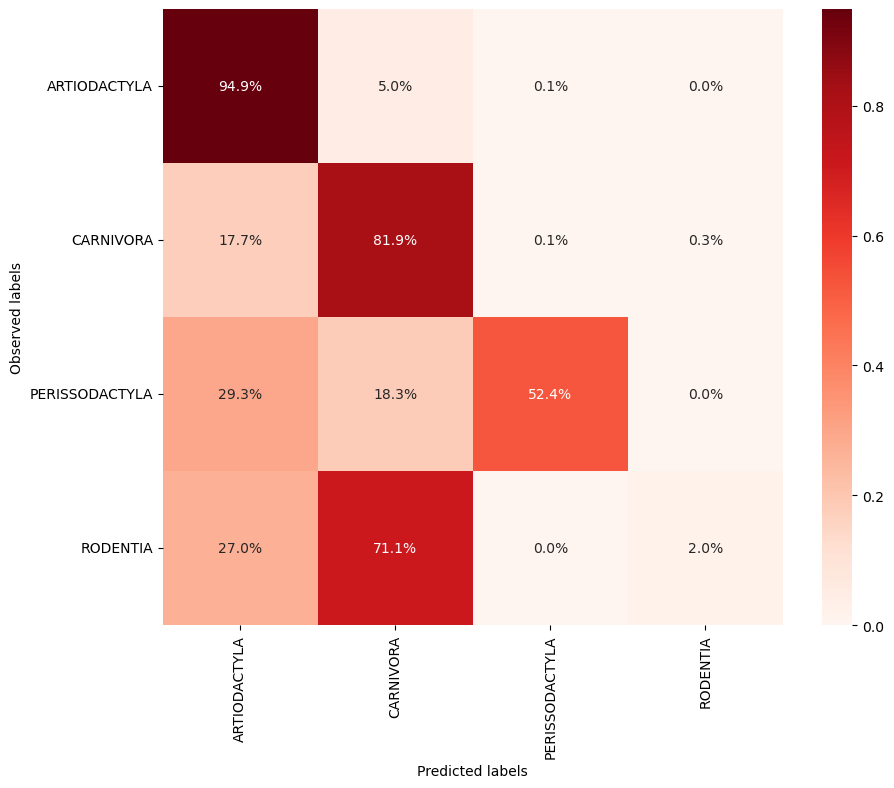

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.7115965666776172 
               0         1
0       antelope  0.989583
1   grizzly+bear  0.700000
2   killer+whale  0.926407
3         beaver  0.085526
4      dalmatian  0.445701
5    persian+cat  0.843072
6          skunk  0.770701
7             ox  1.000000
8            fox  0.903704
9      chihuahua  0.975446
10         otter  0.047297
11         zebra  0.842887
12           pig  0.720430 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7930827237997308 
               0         1
0       antelope  0.996528
1   grizzly+bear  0.739130
2   killer+whale  0.935065
3         beaver  0.203947
4      dalmatian  0.536199
5    persian+cat  0.901503
6          skunk  0.815287
7             ox  1.000000
8            fox  0.955556
9      chihuahua  0.991071
10         otter  0.440878
11         zebra  0.977707
12           pig  0.817204 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.843659365522434 
               0         1
0   

In [43]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 16, 
               bs = 11, 
               numunits = 447, 
               lr = 0.7021105747052101, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.26919069610745244, 
               mom = 0.910874291255116, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.0654                0.6046        0.0273                0.6951     +  1.5479
      2        0.0224                0.7180        0.0210                0.7334     +  1.4909
      3        0.0158                0.7481        0.0190                0.7417     +  1.6652
      4        0.0121                0.7609        0.0177                0.7462     +  1.7265
      5        0.0096                0.7666        0.0174                0.7471     +  1.8349
      6        0.0079                0.7725        0.0171                0.7503     +  1.7523
      7        0.0066                0.7750        0.0170                0.7520     +  1.7815
      8        0.0055                0.7773        0.0170                0.7532        1.7409
      9        0.0047                0.7789    

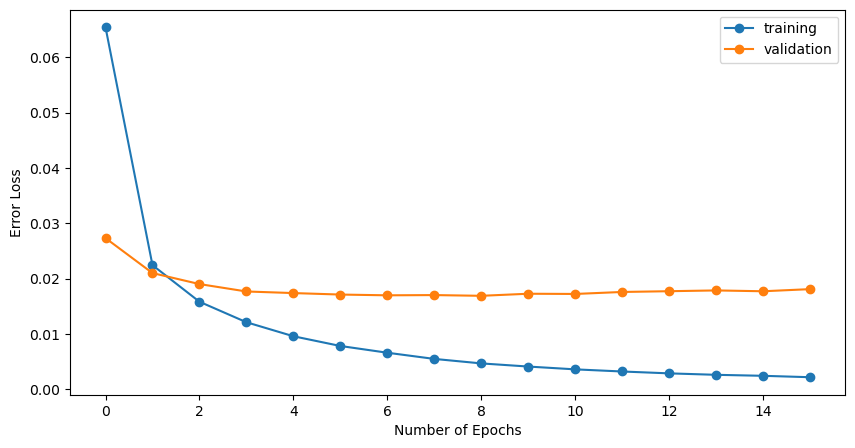

Trianing Recall Macro Curve


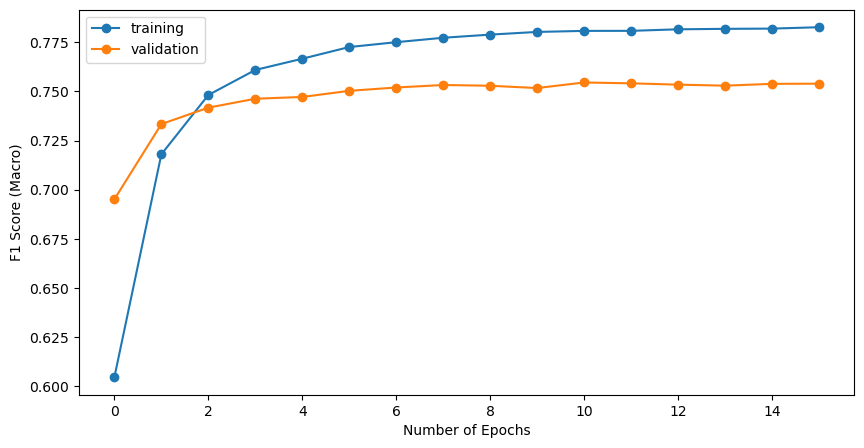

                              precision    recall  f1-score   support

                       black       0.97      0.99      0.98       918
                       white       0.99      0.96      0.97       702
                        blue       0.93      0.92      0.92        60
                       brown       0.98      0.98      0.98      1025
                        gray       0.95      0.95      0.95       451
                      orange       0.96      0.98      0.97       124
                         red       0.93      0.98      0.95        54
                      yellow       0.99      0.97      0.98       139
                     patches       0.96      0.94      0.95       566
                       spots       0.95      0.92      0.93       339
                     stripes       0.99      0.99      0.99       180
                       furry       1.00      1.00      1.00      1463
                    hairless       0.97      0.97      0.97       265
                   

Unseen Class Labels
[10 16 18 25 27 28 29 32 33 35 39 42 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.74      0.90      0.81       400
         moose       0.45      0.80      0.58       554
humpback+whale       0.98      0.97      0.98       565
    chimpanzee       0.82      0.92      0.87       566
      squirrel       0.81      0.17      0.28       961
    rhinoceros       0.87      0.55      0.67       561
        rabbit       0.51      0.84      0.64       877
          wolf       0.36      0.93      0.52       470
     chihuahua       0.76      0.68      0.72       448
        weasel       0.26      0.59      0.36       222
   giant+panda       0.72      0.07      0.12       692
           pig       0.78      0.39      0.51       558
       raccoon       0.42      0.16      0.24       408

      accuracy                           0.59      7282
     macro avg       0.65      0.61      0.56      7282
  weighted avg       0.68      0.59      0.55      7282

Top_1_accuracy for UnSeen Validation split 01

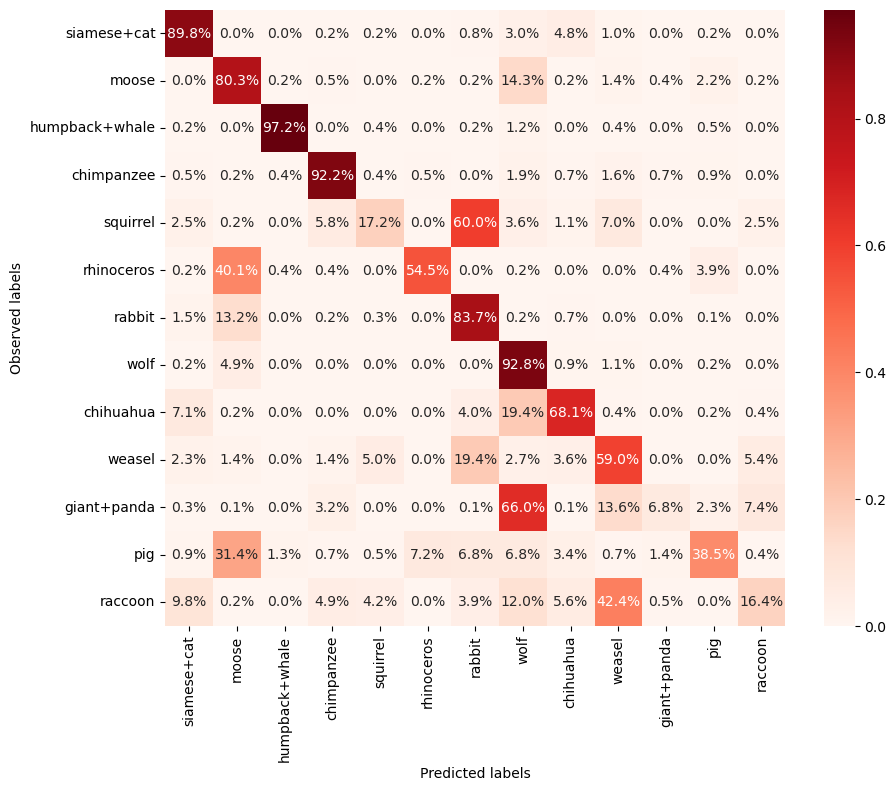

                precision    recall  f1-score   support

  ARTIODACTYLA       0.77      0.84      0.80      1677
     CARNIVORA       0.86      0.92      0.89      2640
    LAGOMORPHA       0.51      0.84      0.64       877
PERISSODACTYLA       0.87      0.55      0.67       561
      PRIMATES       0.82      0.92      0.87       566
      RODENTIA       0.81      0.17      0.28       961

      accuracy                           0.76      7282
     macro avg       0.77      0.71      0.69      7282
  weighted avg       0.79      0.76      0.74      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.83899821 0.92272727 0.83694413 0.54545455 0.92226148 0.17169615]
Top_1_accuracy for UnSeen Validation split 01 -  0.7063469651540001


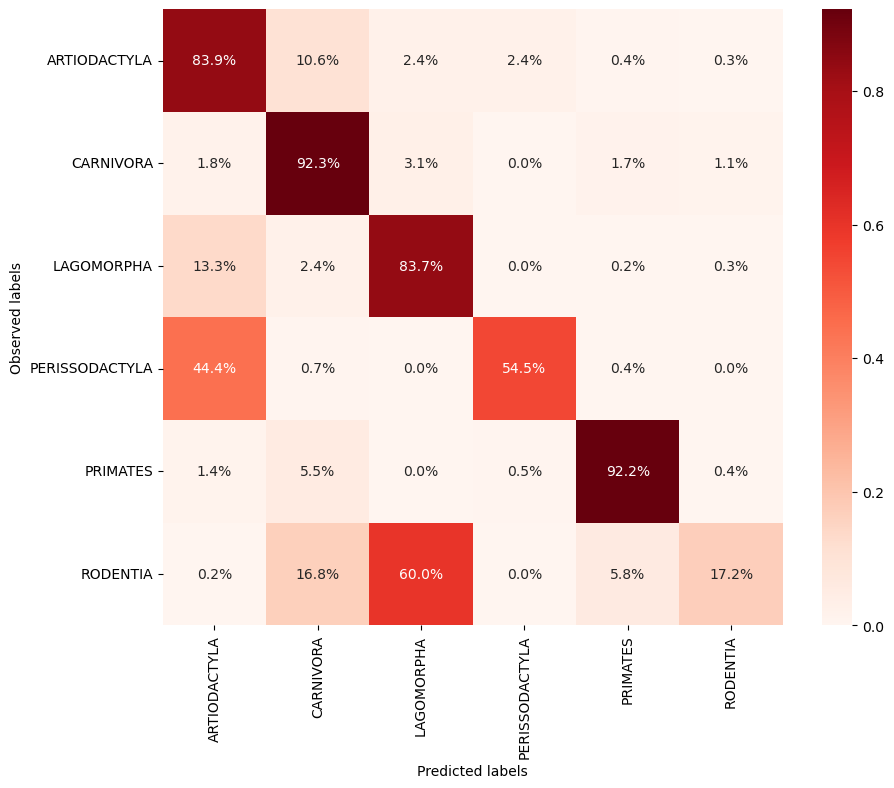

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.798008176296479 
                 0         1
0      siamese+cat  0.945000
1            moose  0.866426
2   humpback+whale  0.975221
3       chimpanzee  0.934629
4         squirrel  0.824142
5       rhinoceros  0.714795
6           rabbit  0.933865
7             wolf  0.974468
8        chihuahua  0.955357
9           weasel  0.707207
10     giant+panda  0.358382
11             pig  0.731183
12         raccoon  0.453431 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.8786324378464377 
                 0         1
0      siamese+cat  0.995000
1            moose  0.879061
2   humpback+whale  0.978761
3       chimpanzee  0.945230
4         squirrel  0.874089
5       rhinoceros  0.962567
6           rabbit  0.969213
7             wolf  0.987234
8        chihuahua  0.968750
9           weasel  0.819820
10     giant+panda  0.539017
11             pig  0.817204
12         raccoon  0.686275 

 Top- 4  Accuracy per class 
 Top- 4  Accurac

In [44]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 16, 
               bs = 11, 
               numunits = 447, 
               lr = 0.7021105747052101, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.26919069610745244, 
               mom = 0.910874291255116, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.0729                0.6566        0.0353                0.7833     +  2.8545
      2        0.0319                0.7957        0.0286                0.8152     +  2.6248
      3        0.0244                0.8303        0.0261                0.8271     +  2.7507
      4        0.0197                0.8461        0.0247                0.8333     +  2.7558
      5        0.0165                0.8577        0.0241                0.8372     +  2.6909
      6        0.0141                0.8636        0.0232                0.8367     +  2.7156
      7        0.0120                0.8699        0.0230                0.8370     +  2.5632
      8        0.0102                0.8746        0.0229                0.8396     +  2.5908
      9        0.0092                0.8773    

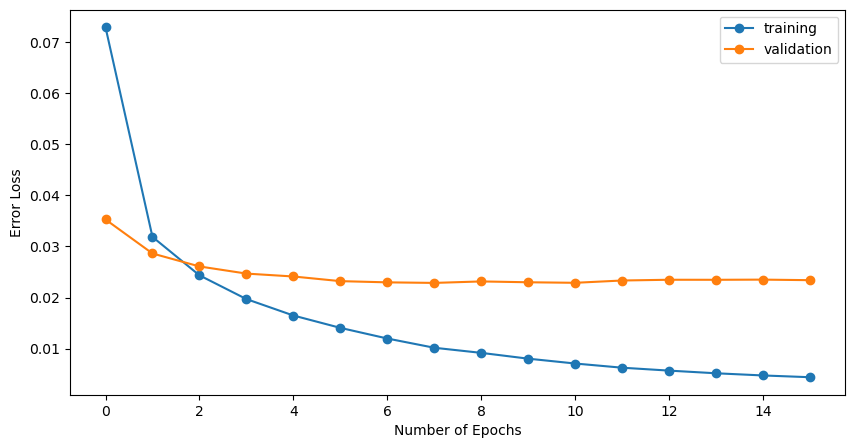

Trianing Recall Macro Curve


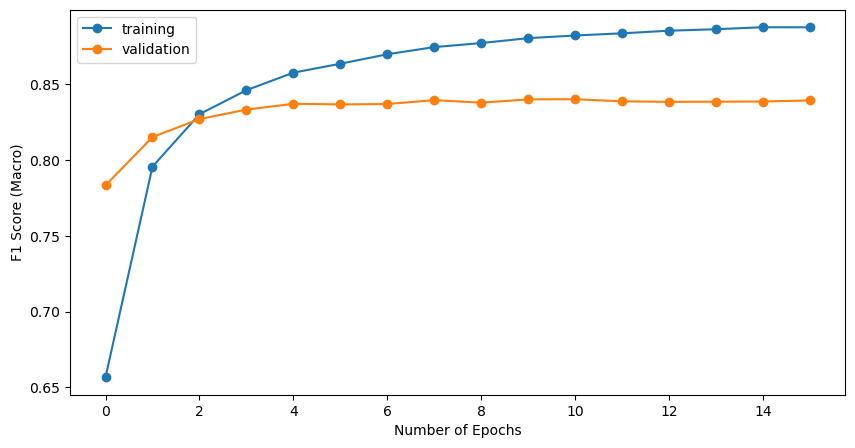

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.21      0.22      0.21      1645
  blue+whale       0.14      0.98      0.25       174
       sheep       0.34      0.31      0.32      1420
        seal       0.78      0.47      0.59       988
         bat       0.00      0.00      0.00       383
     giraffe       0.49      0.50      0.49      1202
         rat       0.54      0.95      0.69       310
      bobcat       0.68      0.96      0.79       630
      walrus       0.31      0.08      0.13       215
     dolphin       0.87      0.37      0.52       946

    accuracy                           0.42      7913
   macro avg       0.44      0.48      0.40      7913
weighted avg       0.47      0.42      0.41      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.21580547 0.98275862 0.31126761 0.47368421 0.         0.49916805
 0.95483871 0.95873016 0.07906977 0.37420719]
Top_1_accuracy for UnSeen Validation split 01 -  0.4849529785229102


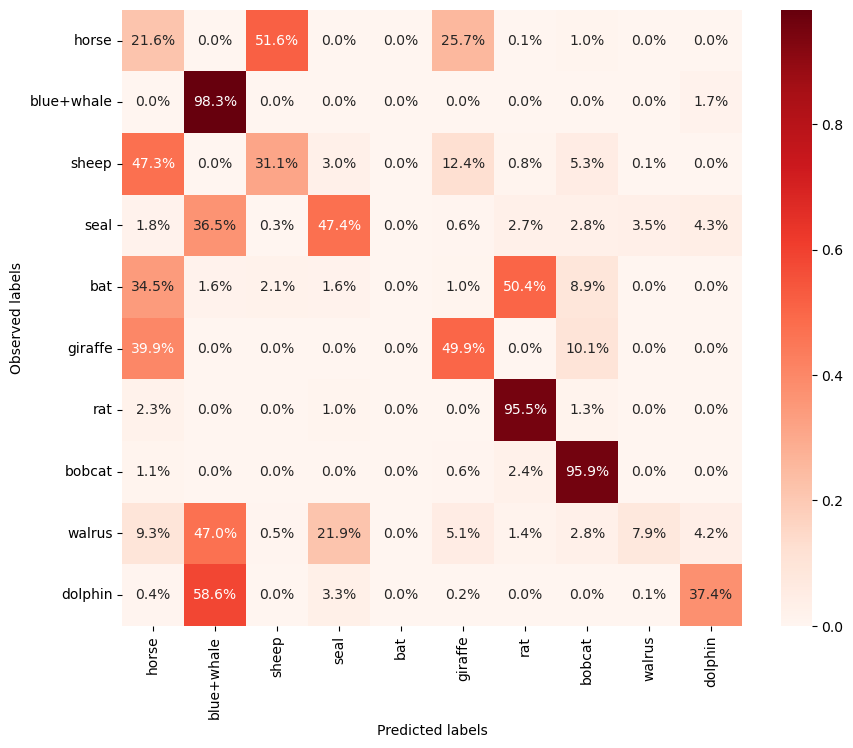

                precision    recall  f1-score   support

  ARTIODACTYLA       0.56      0.62      0.58      3742
     CARNIVORA       0.78      0.66      0.71      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.21      0.22      0.21      1645
      RODENTIA       0.54      0.95      0.69       310

      accuracy                           0.53      7913
     macro avg       0.42      0.49      0.44      7913
  weighted avg       0.51      0.53      0.51      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.61517905 0.65739225 0.         0.21580547 0.95483871]
Top_1_accuracy for UnSeen Validation split 01 -  0.48864309651521315


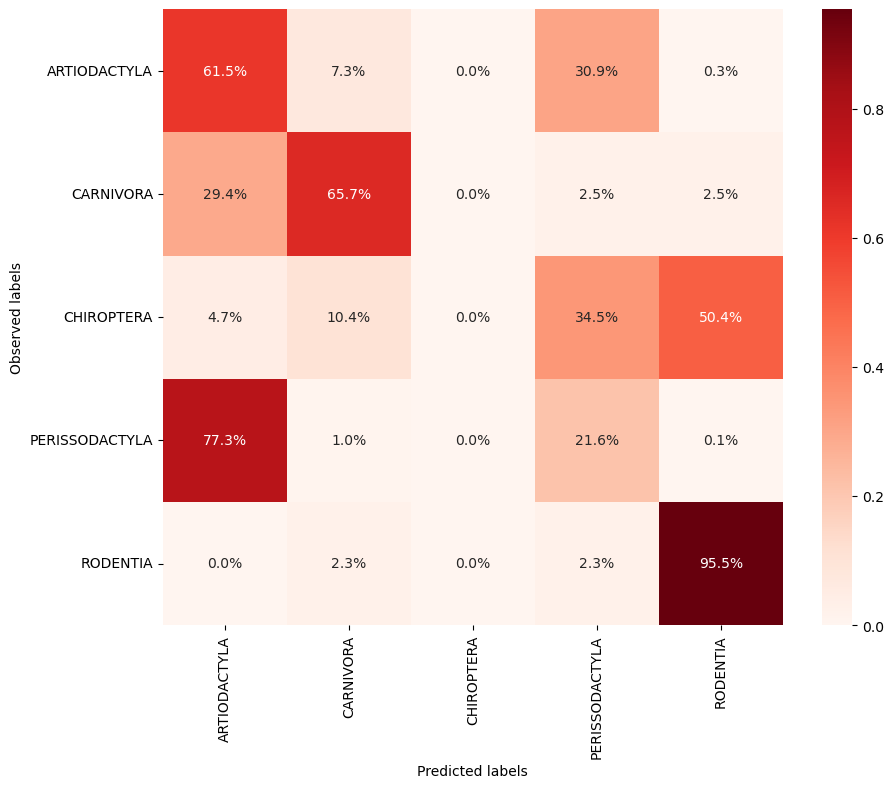

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6981450846798885 
            0         1
0       horse  0.413982
1  blue+whale  1.000000
2       sheep  0.613380
3        seal  0.589069
4         bat  0.083551
5     giraffe  0.856073
6         rat  0.983871
7      bobcat  0.982540
8      walrus  0.525581
9     dolphin  0.933404 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.8385845244359187 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.825352
3        seal  0.733806
4         bat  0.248042
5     giraffe  0.960899
6         rat  0.993548
7      bobcat  0.992063
8      walrus  0.651163
9     dolphin  0.980973 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.9340736862833238 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.859155
3        seal  0.959514
4         bat  0.676240
5     giraffe  0.986689
6         rat  0.996774
7      bobcat  0.996825
8      walrus  0.869767
9     dolphin  0.9

In [30]:
Test01 = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 16, 
               bs = 11, 
               numunits = 447, 
               lr = 0.7021105747052101, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.26919069610745244, 
               mom = 0.910874291255116, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

 # 11. CZSL on Unseen Test Set using non optimised parameters

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.2848                0.1423        0.2544                0.1614     +  2.5135
      2        0.2331                0.1859        0.2092                0.2102     +  2.8655
      3        0.1927                0.2358        0.1747                0.2611     +  2.6395
      4        0.1639                0.2948        0.1512                0.3246     +  2.6031
      5        0.1443                0.3523        0.1350                0.3759     +  2.5251
      6        0.1305                0.4001        0.1232                0.4217     +  2.8926
      7        0.1202                0.4438        0.1142                0.4643     +  2.6353
      8        0.1123                0.4819        0.1070                0.4986     +  2.6425
      9        0.1056                0.5124    

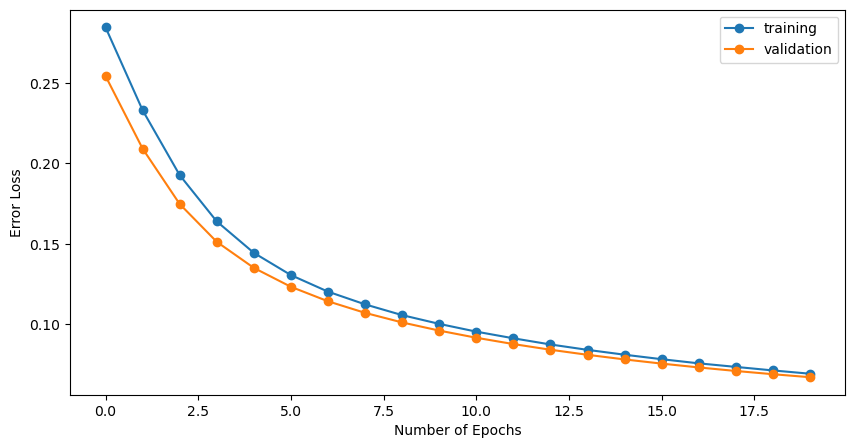

Trianing Recall Macro Curve


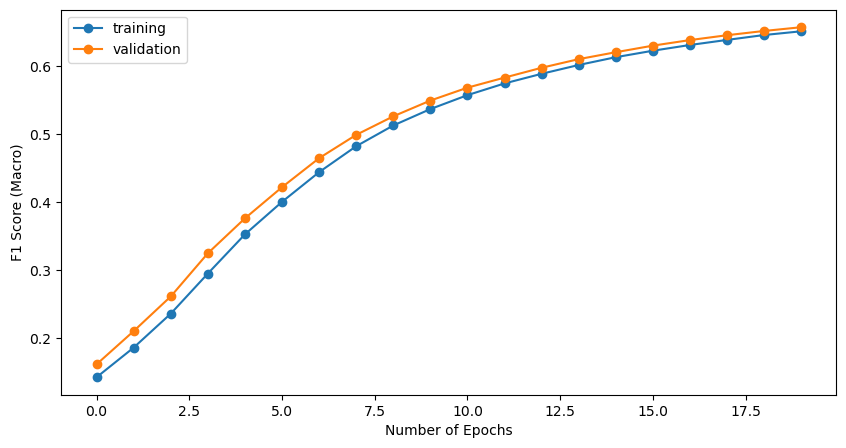

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.29      0.47      0.36      1645
  blue+whale       0.11      1.00      0.19       174
       sheep       0.60      0.41      0.49      1420
        seal       0.86      0.30      0.45       988
         bat       0.00      0.00      0.00       383
     giraffe       0.15      0.10      0.12      1202
         rat       0.58      0.92      0.71       310
      bobcat       0.76      0.97      0.85       630
      walrus       0.21      0.12      0.15       215
     dolphin       0.74      0.05      0.10       946

    accuracy                           0.37      7913
   macro avg       0.43      0.43      0.34      7913
weighted avg       0.48      0.37      0.35      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.47112462 1.         0.41408451 0.30465587 0.         0.09650582
 0.91935484 0.96825397 0.11627907 0.05179704]
Top_1_accuracy for UnSeen Validation split 01 -  0.4342055738075897


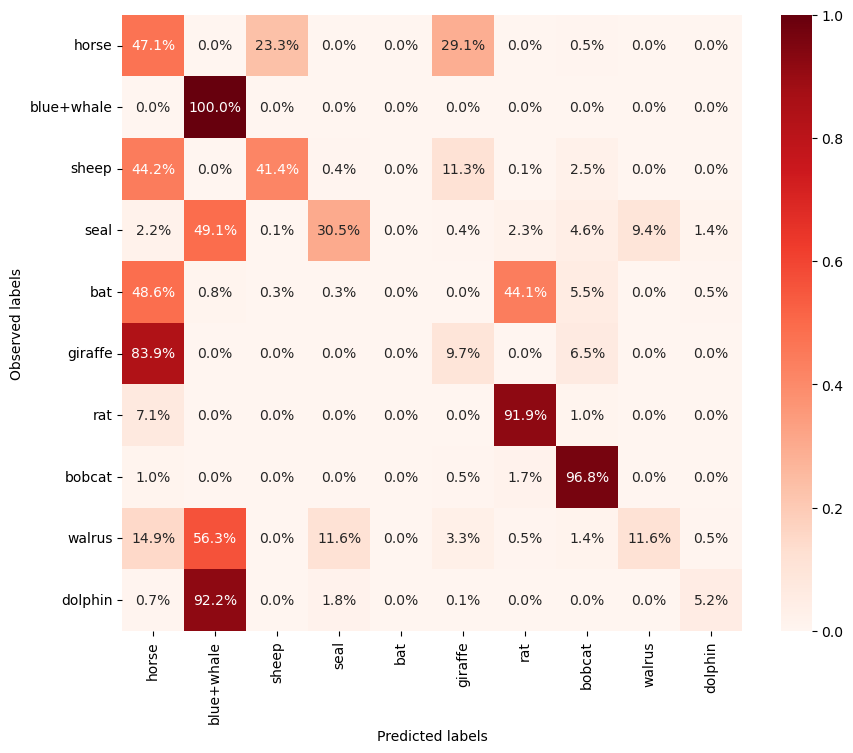

                precision    recall  f1-score   support

  ARTIODACTYLA       0.57      0.52      0.54      3742
     CARNIVORA       0.87      0.60      0.71      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.29      0.47      0.36      1645
      RODENTIA       0.58      0.92      0.71       310

      accuracy                           0.52      7913
     macro avg       0.46      0.50      0.46      7913
  weighted avg       0.55      0.52      0.52      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.52405131 0.60120022 0.         0.47112462 0.91935484]
Top_1_accuracy for UnSeen Validation split 01 -  0.5031461972904289


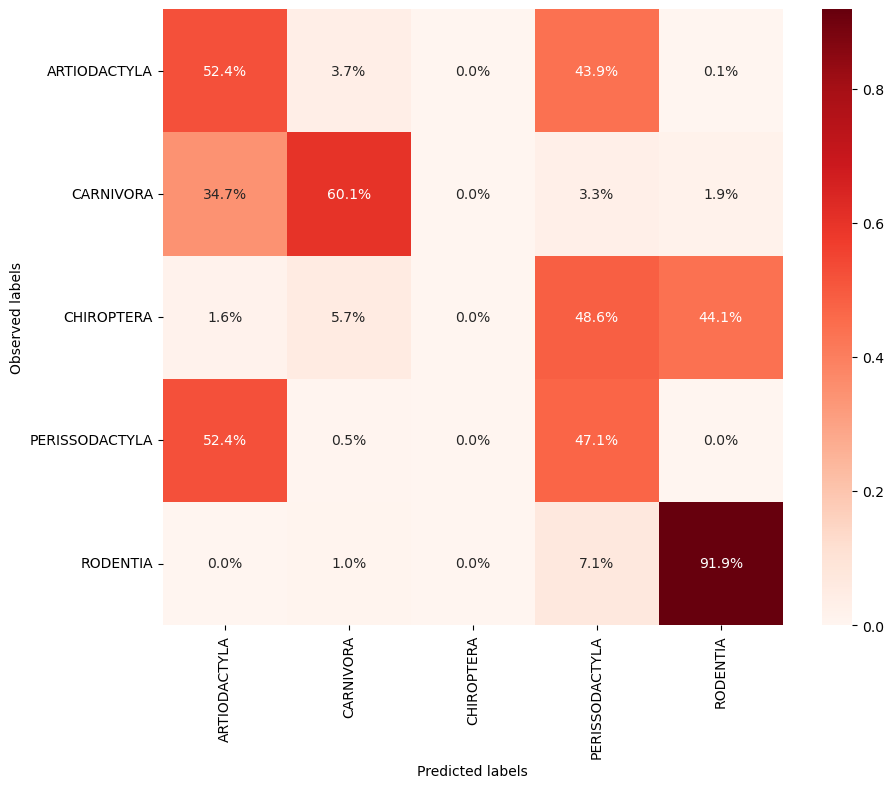

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.7279658828662354 
            0         1
0       horse  0.723404
1  blue+whale  1.000000
2       sheep  0.709155
3        seal  0.519231
4         bat  0.026110
5     giraffe  0.862729
6         rat  0.970968
7      bobcat  0.987302
8      walrus  0.544186
9     dolphin  0.936575 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.8596617409027939 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.926761
3        seal  0.892713
4         bat  0.154047
5     giraffe  0.983361
6         rat  1.000000
7      bobcat  0.990476
8      walrus  0.665116
9     dolphin  0.984144 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.9318726420473 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.952817
3        seal  0.974696
4         bat  0.532637
5     giraffe  0.999168
6         rat  1.000000
7      bobcat  1.000000
8      walrus  0.860465
9     dolphin  0.9989

In [18]:
Test02 = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard